# Project: Wrangle and Analyze Data

By: Ayush Gupta

## Table of Contents

- <a href="#intro">Introduction</a>
- <a href="#sources">Data Sources</a>
- <a href="#gathering">Data Gathering</a>
- <a href="#assessing">Data Assessment</a>
    - <a href="#assessingsmentsum">Assessment Summary</a>
- <a href="#cleaning">Data Cleaning</a>
- <a href="#analysis">Data Analysis</a>
- <a href="#conclusion">Summary and Conclusions</a>
- <a href="#sources">Sources Referred</a>

<a id='intro'></a>
## Introduction

In the following project I am going to gather and analyze data all around the Twitter account <a href = "https://twitter.com/dog_rates">"WeRateDogs"</a>. Data is obtained using three different methods - manual download, programmatically download and over an API. After that I am going to assess this data, define the issues found during the assessment and clean these issues to get a cleaned master dataframe. This data will then be analyzed to draw some useful insights.

<a id='sources'></a>
## Data Sources


1. **Source:** WeRateDogs Twitter Archive (twitter-archive-enhanced.csv)
    - Origin: <a href = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv">Udacity</a>
    - Version: Latest (Downloaded 03/05/2020)
    - Method of gathering: Manual download


2. **Source:** Tweet image predictions (image_predictions.tsv)</li>
    - Origin: <a href="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv">Udacity</a>     
    - Version: Latest (Downloaded 03/05/2020)
    - Method of gathering: Programmatically download via Requests


3. **Source:** Additional Twitter data (tweet_json.txt)
    - Origin: <a href = "https://twitter.com/dog_rates">WeRateDogs</a>   
    - Version: Latest (Collected 03/05/2020)
    - Method of gathering: Twitter API via Tweepy

In [436]:
import json
import re

import matplotlib.pyplot as plt
import missingno as ms
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tweepy

<a id='gathering'></a>
## Data Gathering

### 1. WeRateDogs Twitter Archive (twitter-archive-enhanced.csv)

The file is downloaded from Udacity. Now the file can be loaded directly into a dataframe via Pandas.

In [437]:
df_twitter = pd.read_csv("../data/raw/twitter-archive-enhanced.csv")

df_twitter.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


### 2. Tweet image predictions (image_predictions.tsv)

To gather this data we are going to define the file - url, request this url and write the content of the response to a separate file.

In [438]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

# get response
response = requests.get(url)

# write return to an image
with open("../data/raw/image_predictions.tsv", mode="wb") as file:
    file.write(response.content)

In [439]:
df_predict = pd.read_csv("../data/raw/image_predictions.tsv", sep="\t")

df_predict.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


### 3. Additional Twitter data (tweet_json.txt)

To gather the data from the Twitter API I created a Twitter developer account and gathered the data via tweepy. This results in a new file called "tweet_json.txt".

In [440]:
from timeit import default_timer as timer

consumer_key = "<your key here>"
consumer_secret = "<your secret here>"
access_token = "<your key here>"
access_secret = "<your secret here>"


def scrape_twitter_timeline():
    # access the API
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # get all the twitter ids in the df
    twitter_ids = list(df_twitter.tweet_id.unique())

    # save the gathered data to a file
    start = timer()
    with open("../data/raw/tweet_json.txt", "w") as file:
        for ids in twitter_ids:
            print(f"Gather id: {ids}")
            try:
                # get all the twitter status - extended mode gives us additional data
                tweet = api.get_status(ids, tweet_mode="extended")
                # dump the json data to our file
                json.dump(tweet._json, file)
                # add a linebreak after each dump
                file.write("\n")
            except Exception as e:
                print(f"Error - id: {ids}" + str(e))
    end = timer()
    print(end - start)

Now we can read in all the necessary data into a dictionary to create a dataframe.

In [441]:
api_data = []

# scrape_twitter_timeline()

# read the created file
with open("../data/raw/tweet_json.txt", "r") as f:
    for line in f:
        try:
            tweet = json.loads(line)
            # append a dictionary to the created list
            api_data.append(
                {
                    "tweet_id": tweet["id"],
                    "retweet_count": tweet["retweet_count"],
                    "favorite_count": tweet["favorite_count"],
                    "retweeted": tweet["retweeted"],
                    "display_text_range": tweet["display_text_range"],
                }
            )

            # tweet["entities"]["media"][0]["media_url"]
        except:
            print("Error.")

df_api = pd.DataFrame(
    api_data,
    columns=[
        "tweet_id",
        "retweet_count",
        "favorite_count",
        "retweeted",
        "display_text_range",
    ],
)
df_api.head()

,tweet_id,retweet_count,favorite_count,retweeted,display_text_range
0,892420643555336193,7728,36324,False,"[0, 85]"
1,892177421306343426,5721,31299,False,"[0, 138]"
2,891815181378084864,3786,23580,False,"[0, 121]"
3,891689557279858688,7884,39619,False,"[0, 79]"
4,891327558926688256,8512,37814,False,"[0, 138]"


Let's do a final check on the dataframes

In [442]:
df_twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


In [443]:
df_predict.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [444]:
df_api.head(1)

,tweet_id,retweet_count,favorite_count,retweeted,display_text_range
0,892420643555336193,7728,36324,False,"[0, 85]"


<a id='assessing'></a>
## Data Assessment

Now we are going to look for issues with the quality or the tidiness of the data and its dimensions.

#### df_twitter

Let's first look for missing data.

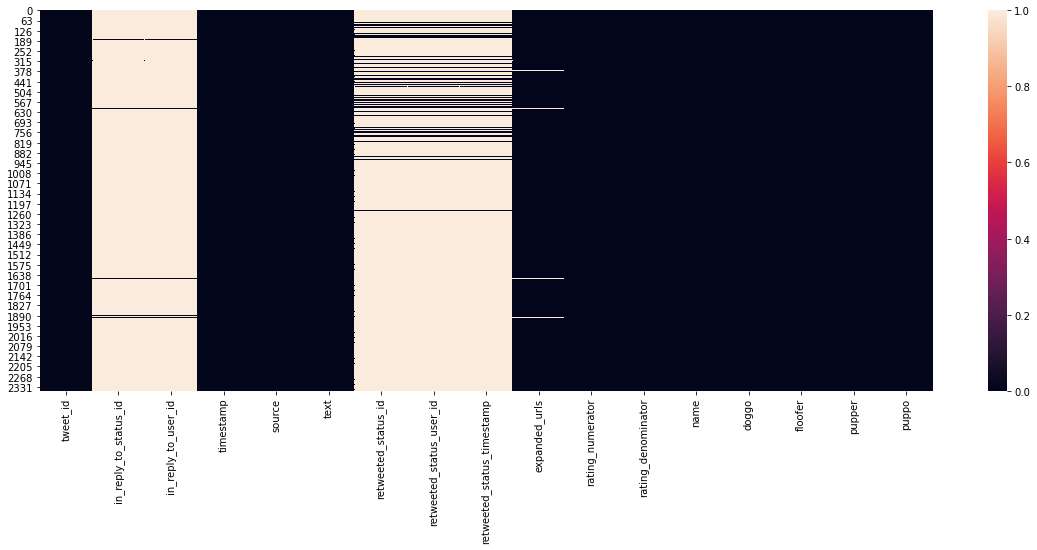

In [445]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(df_twitter.isnull(), vmin=0, vmax=1)

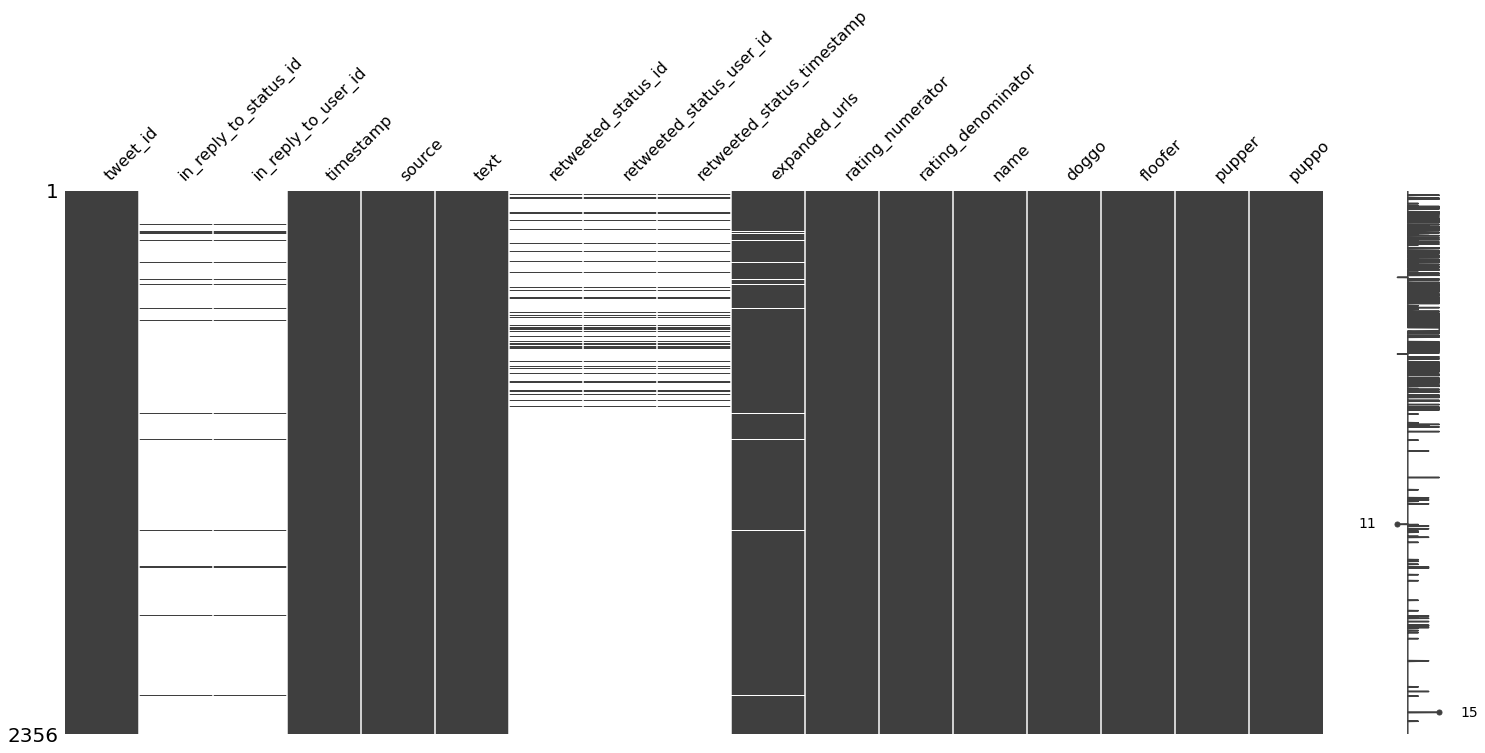

In [446]:
ms.matrix(df_twitter)

As we can see, there is a lot of missing data in the columns about the reply and the retweeted status. Since we only want original posts with images, we have to drop them later - the missing data in the "expanded_urls" column will also disappear with the cleaning operation. The matrix does show a little more detail here than the chart.

In [447]:
df_twitter.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
247,845459076796616705,NaN,NaN,2017-03-25 02:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Here's a heartwarming scene of a single father raising his two pups. Downright awe-inspiring af. 12/10 for everyone https://…,7.562885e+17,4.196984e+09,2016-07-22 00:43:32 +0000,"https://twitter.com/dog_rates/status/756288534030475264/photo/1,https://twitter.com/dog_rates/status/756288534030475264/photo/1,https://twitter.com/dog_rates/status/756288534030475264/photo/1,https://twitter.com/dog_rates/status/756288534030475264/photo/1",12,10,None,None,None,None,None
54,881666595344535552,NaN,NaN,2017-07-03 00:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Gary. He couldn't miss this puppertunity for a selfie. Flawless focusing skills. 13/10 would boop intensely https://t.co/7CSWCl8I6s,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881666595344535552/photo/1,13,10,Gary,None,None,None,None
189,855860136149123072,8.558585e+17,13615722.0,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
1373,701981390485725185,NaN,NaN,2016-02-23 04:06:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Fiji. She's a Powdered Stegafloof. Very rare. 12/10 https://t.co/fZRob6eotY,NaN,NaN,NaN,https://twitter.com/dog_rates/status/701981390485725185/photo/1,12,10,Fiji,None,None,None,None
1978,672984142909456390,NaN,NaN,2015-12-05 03:41:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Very happy pup here. Always smiling. Loves his little leaf. Carries it everywhere with him. 9/10 https://t.co/81BCQAyvcs,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672984142909456390/photo/1,9,10,None,None,None,None,None


During the visual assessment we can observe that:

- Not all tweets could be classified as doggo, floofer, pupper or puppo and all columns contain "None"
- The source contains unnecessary HTML code
- There is the name "None" in the name column

In [448]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Also the datatypes are incorrect:
- tweet_id should be a str
- timestamp - columns should be datetime objects

Now let's see how many wrong names we can find.

In [449]:
df_twitter.name.value_counts()

None       745
a          55 
Charlie    12 
Cooper     11 
Lucy       11 
           .. 
Jeremy     1  
Gòrdón     1  
Coleman    1  
Marq       1  
Pluto      1  
Name: name, Length: 957, dtype: int64

As we can see, the name column contains wrong names like "None", "a", "the", "an".

In [450]:
df_twitter[df_twitter.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


There are no duplicates in this data, so the number of unique tweet_ids should be the length of the df.

In [451]:
df_twitter.tweet_id.nunique()

2356

Proof. Now let's create a copy of the twitter dataframe for further assessing. I want to see in how many cases there were no classification of dog_size possible via text processing.

In [452]:
df_twitter_assess = df_twitter.copy()

In [453]:
# returns true if there is no dog classification in any of the columns
df_twitter_assess[["doggo", "floofer", "pupper", "puppo"]].apply(
    lambda x: True
    if (x[0] == "None" and x[1] == "None" and x[2] == "None" and x[3] == "None")
    else False,
    axis=1,
).value_counts()

True     1976
False    380 
dtype: int64

In [454]:
df_twitter_assess["doggo"].value_counts()

None     2259
doggo    97  
Name: doggo, dtype: int64

In [455]:
df_twitter_assess["floofer"].value_counts()

None       2346
floofer    10  
Name: floofer, dtype: int64

In [456]:
df_twitter_assess["pupper"].value_counts()

None      2099
pupper    257 
Name: pupper, dtype: int64

In [457]:
df_twitter_assess["puppo"].value_counts()

None     2326
puppo    30  
Name: puppo, dtype: int64

Only for 16% of the rows the data is not missing. Now let's take a look at the ratings. By what we have seen so far, it looks like the ratings have always a format of 13/10 or 12/10 and so on. So we would expect a numerator > 10 and denominator = 10.

In [458]:
df_twitter.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

We can observe that there is a wide range of numbers as rating_numerator, with a maximum of 1776.

In [459]:
print(df_twitter.query("rating_numerator == '1776'").text)

979    This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
Name: text, dtype: object


This rating is correct - so a lot higher values as 12 or 13 would be valid to this rating system. But what is with the very small ones?

In [460]:
print(df_twitter.query("rating_numerator == '1'").text)

605     RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…
1446    After reading the comments I may have overestimated this pup. Downgraded to a 1/10. Please forgive me                                       
1869    What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0                   
1940    The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you                                                    
2038    After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes     
2091    Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO    
2261    Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not e

The entry 605 shows, that these tweets contain pictures that don't contain any dogs. Also in the entry 2335 the rating got extracted wrongly (misinterpreted the 1/2 of 3 1/2 as the rating).

In [461]:
print(df_twitter.query("rating_numerator == '0'").text)

315     When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag      
1016    PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX
Name: text, dtype: object


No clear doggo photos again. Let's make the same check for the denominator.

In [462]:
df_twitter.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [463]:
print(df_twitter.query("rating_denominator == '170'").text)

1120    Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
Name: text, dtype: object


In [464]:
print(df_twitter.query("rating_denominator == '0'").text)

313    @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Name: text, dtype: object


In [465]:
print(df_twitter.query("rating_denominator == '7'").text)

516    Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
Name: text, dtype: object


The same problems as for the numerator. Multiple Dogs or multiple occurences of the pattern `\d+/\d+`. Lets extract this and see what we get.

In [466]:
# we could expect an integer rating on what we saw, but maybe some floats are the case
pattern = "(\d+(\.\d+)?\/\d+(\.\d+)?)"

df_twitter_assess["rating"] = df_twitter_assess.text.str.extract(pattern, expand=True)[
    0
]

df_twitter_assess[["num", "denom"]] = df_twitter_assess["rating"].str.split(
    "/", n=1, expand=True
)

df_twitter_assess.rating_numerator = df_twitter_assess.rating_numerator.astype("str")
df_twitter_assess.rating_denominator = df_twitter_assess.rating_denominator.astype(
    "str"
)

# look for differences in the original numerator and the newe extract
df_twitter_assess["check_num"] = df_twitter_assess[["rating_numerator", "num"]].apply(
    lambda x: False if (x[0] != x[1]) else True, axis=1
)

In [467]:
df_twitter_assess.check_num.value_counts()

True     2349
False    7   
Name: check_num, dtype: int64

In [468]:
df_twitter_assess.query("check_num == False")[["rating_numerator", "num", "check_num"]]

,rating_numerator,num,check_num
45,5,13.5,False
340,75,9.75,False
387,7,007,False
695,75,9.75,False
763,27,11.27,False
1689,5,9.5,False
1712,26,11.26,False


These are the differences we found by extracting the first occurrence of the pattern. These ratings got transformed to integers and are therefore wrong.

In [469]:
df_twitter_assess[["rating_numerator", "num", "check_num"]].sample(15)

,rating_numerator,num,check_num
1157,10,10,True
351,12,12,True
1322,11,11,True
983,10,10,True
2194,11,11,True
1107,11,11,True
1658,10,10,True
1724,12,12,True
531,12,12,True
2313,10,10,True


Let's repeat this for the denominator.

In [470]:
df_twitter_assess["check_denom"] = df_twitter_assess[
    ["rating_denominator", "denom"]
].apply(lambda x: False if (x[0] != x[1]) else True, axis=1)

df_twitter_assess.check_denom.value_counts()

True     2355
False    1   
Name: check_denom, dtype: int64

In [471]:
df_twitter_assess.query("check_denom == False")[
    ["rating_denominator", "denom", "check_denom"]
]  # problem with integer, maybe also floats?

,rating_denominator,denom,check_denom
313,0,00,False


This seems like something we don't have to worry about.

In [472]:
df_twitter_assess[["rating_denominator", "denom", "check_denom"]].sample(5)

,rating_denominator,denom,check_denom
1962,10,10,True
964,10,10,True
514,10,10,True
1310,10,10,True
1466,10,10,True


Now we should assess how often there are multiple occurrences of the "rating pattern" in one tweet clear

In [473]:
df_twitter_assess["count"] = df_twitter_assess.text.str.count(pattern)

In [474]:
df_twitter_assess["count"].value_counts()

1    2323
2    32  
3    1   
Name: count, dtype: int64

In [475]:
# show the full text
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 4000)

df_twitter_assess[["text", "count"]].query("count != 1")

,text,count
55,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,2
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",2
561,"RT @dog_rates: ""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",2
766,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",2
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",2
860,RT @dog_rates: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https:/…,2
1007,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,2
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",2
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,2
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,2


We can see that:
- This data contains retweets (as mentioned before)
- Sometimes there are multiple dogs/cats or else in one picture
- Some of these ratings are not clear

#### df_predict

Let's also begin with the missing data first.

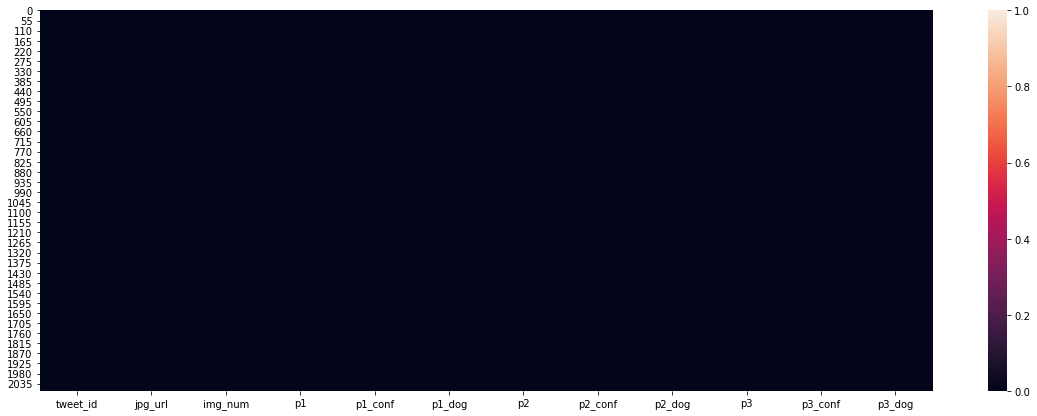

In [476]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(df_predict.isnull(), vmin=0, vmax=1)

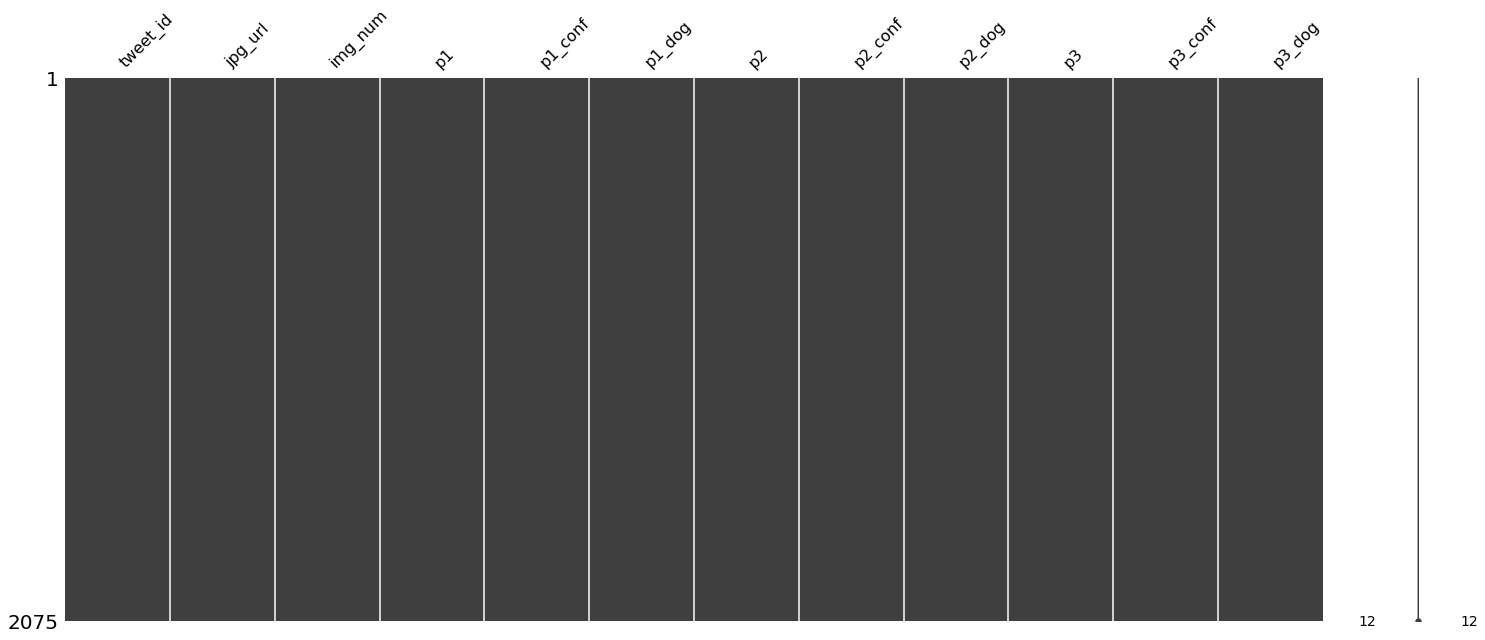

In [477]:
ms.matrix(df_predict)

Looks fine. Now the visual assessment:

In [478]:
df_predict.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
541,677187300187611136,https://pbs.twimg.com/media/CWXaQMBWcAAATDi.jpg,1,English_setter,0.282396,True,Shih-Tzu,0.084112,True,Old_English_sheepdog,0.059538,True
569,678389028614488064,https://pbs.twimg.com/media/CWofOHUWUAACGVa.jpg,1,miniature_pinscher,0.516284,True,kelpie,0.227402,True,vizsla,0.103246,True
69,667188689915760640,https://pbs.twimg.com/media/CUJUk2iWUAAVtOv.jpg,1,vacuum,0.335830,False,swab,0.265278,False,toilet_tissue,0.140703,False
2009,878281511006478336,https://pbs.twimg.com/media/DDBIX9QVYAAohGa.jpg,1,basset,0.320420,True,collie,0.215975,True,Appenzeller,0.128507,True
1623,803638050916102144,https://pbs.twimg.com/ext_tw_video_thumb/803638023904559104/pu/img/vxm0Htm5iIV7EOAQ.jpg,1,Labrador_retriever,0.372776,True,golden_retriever,0.343666,True,Great_Pyrenees,0.067242,True
546,677328882937298944,https://pbs.twimg.com/media/CWZbBlAUsAAjRg5.jpg,1,water_buffalo,0.424250,False,kelpie,0.029054,True,Staffordshire_bullterrier,0.028470,True
141,668567822092664832,https://pbs.twimg.com/media/CUc64knWoAkZt70.jpg,1,Shih-Tzu,0.985649,True,Lhasa,0.007078,True,Pekinese,0.003053,True
1584,797236660651966464,https://pbs.twimg.com/media/CxBafisWQAAtJ1X.jpg,2,collie,0.767005,True,Border_collie,0.100844,True,kelpie,0.048368,True
697,684538444857667585,https://pbs.twimg.com/ext_tw_video_thumb/684538367950872576/pu/img/kTKOkSU45BS-fpq8.jpg,1,Chihuahua,0.702583,True,Siamese_cat,0.068218,False,macaque,0.043325,False
1163,735137028879360001,https://pbs.twimg.com/media/CjO7OfeWgAAUQy-.jpg,1,Walker_hound,0.413535,True,beagle,0.233891,True,English_foxhound,0.164943,True


We can see that:
- The predicitions are sometimes lowercase, sometimes uppercase
- There is an underscore instead of a whitespace between the words
- There are rows with no prediciton of a dog (neither in 1, 2 nor 3)

In [479]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


The tweet_id column should again be string

The best way to find duplicates is to look at the jpg - url. If there are value counts > 1, then this data contains duplicates/retweets.

In [480]:
df_predict.jpg_url.value_counts().head(10)

https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg                                            2
https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg                                            2
https://pbs.twimg.com/media/CmoPdmHW8AAi8BI.jpg                                            2
https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg                                            2
https://pbs.twimg.com/media/CVuQ2LeUsAAIe3s.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg    2
https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg                                            2
https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg                                            2
https://pbs.twimg.com/media/CvyVxQRWEAAdSZS.jpg                                            2
https://pbs.twimg.com/media/CiibOMzUYAA9Mxz.jpg                                            2
Name: jpg_url, dtype: int64

As predicted - this data contains retweets.

In [481]:
df_predict[df_predict.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [482]:
df_predict[df_predict.jpg_url == "https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg"]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1045,712809025985978368,https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg,1,Labrador_retriever,0.868671,True,carton,0.095095,False,pug,0.007651,True
1594,798697898615730177,https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg,1,Labrador_retriever,0.868671,True,carton,0.095095,False,pug,0.007651,True


In [483]:
df_twitter[df_twitter.tweet_id == 798697898615730177]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
596,798697898615730177,NaN,NaN,2016-11-16 01:23:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Stubert. He just arrived. 10/10 https://t.co/HVGs5aAKAn,7.128090e+17,4.196984e+09,2016-03-24 01:11:29 +0000,"https://twitter.com/dog_rates/status/712809025985978368/photo/1,https://twitter.com/dog_rates/status/712809025985978368/photo/1",10,10,Stubert,None,None,None,None


We only want tweets with pictures which contain dogs. Let's see if there are pictures, for which the ML - Algorithm didn't predict any dogs.

In [484]:
df_predict.query("p1_dog == False and p2_dog == False and p3_dog == False")

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


In [485]:
df_predict.query("p1_dog == False and (p2_dog == True or p3_dog == True)")

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
22,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,ox,0.416669,False,Newfoundland,0.278407,True,groenendael,0.102643,True
33,666430724426358785,https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg,1,llama,0.505184,False,Irish_terrier,0.104109,True,dingo,0.062071,False
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,0.167175,True,Chihuahua,0.086951,True
52,666996132027977728,https://pbs.twimg.com/media/CUGlb6iUwAITEbW.jpg,1,hay,0.507637,False,Rottweiler,0.062490,True,water_buffalo,0.048425,False
87,667524857454854144,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,1,hare,0.447893,False,dhole,0.092435,False,Chesapeake_Bay_retriever,0.088122,True
95,667550904950915073,https://pbs.twimg.com/media/CUOb_gUUkAACXdS.jpg,1,web_site,0.999335,False,vizsla,0.000081,True,collie,0.000069,True
103,667806454573760512,https://pbs.twimg.com/media/CUSGbXeVAAAgztZ.jpg,1,toyshop,0.253089,False,Chihuahua,0.187155,True,Brabancon_griffon,0.112799,True
108,667878741721415682,https://pbs.twimg.com/media/CUTILFiWcAE8Rle.jpg,1,seat_belt,0.200373,False,miniature_pinscher,0.106003,True,schipperke,0.104733,True
113,667915453470232577,https://pbs.twimg.com/media/CUTpj-GWcAATc6A.jpg,1,leatherback_turtle,0.452517,False,boxer,0.196655,True,terrapin,0.160983,False


After checking some of these pictures it gets clear, that sometimes the doggos are in the background or the pictures doesn't contain any dogs at all.

#### df_api

Lets repeat the same pattern for this dataset: missing data and then visual assessment.

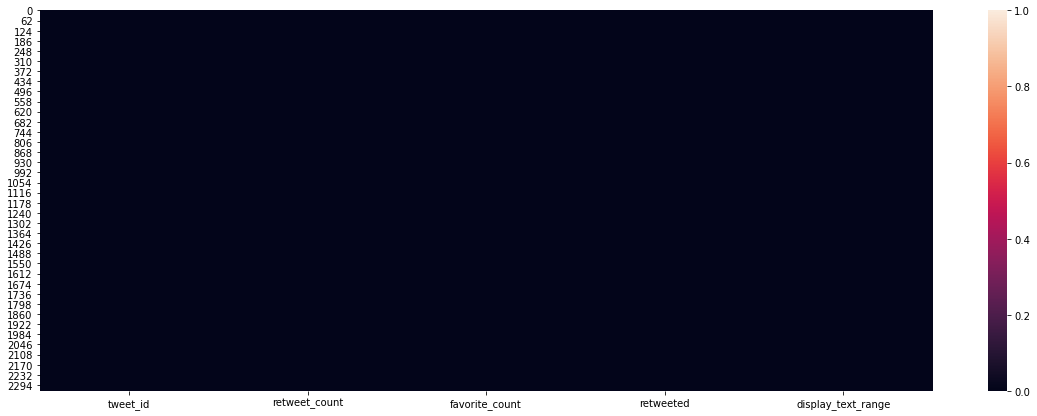

In [486]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(df_api.isnull(), vmin=0, vmax=1)

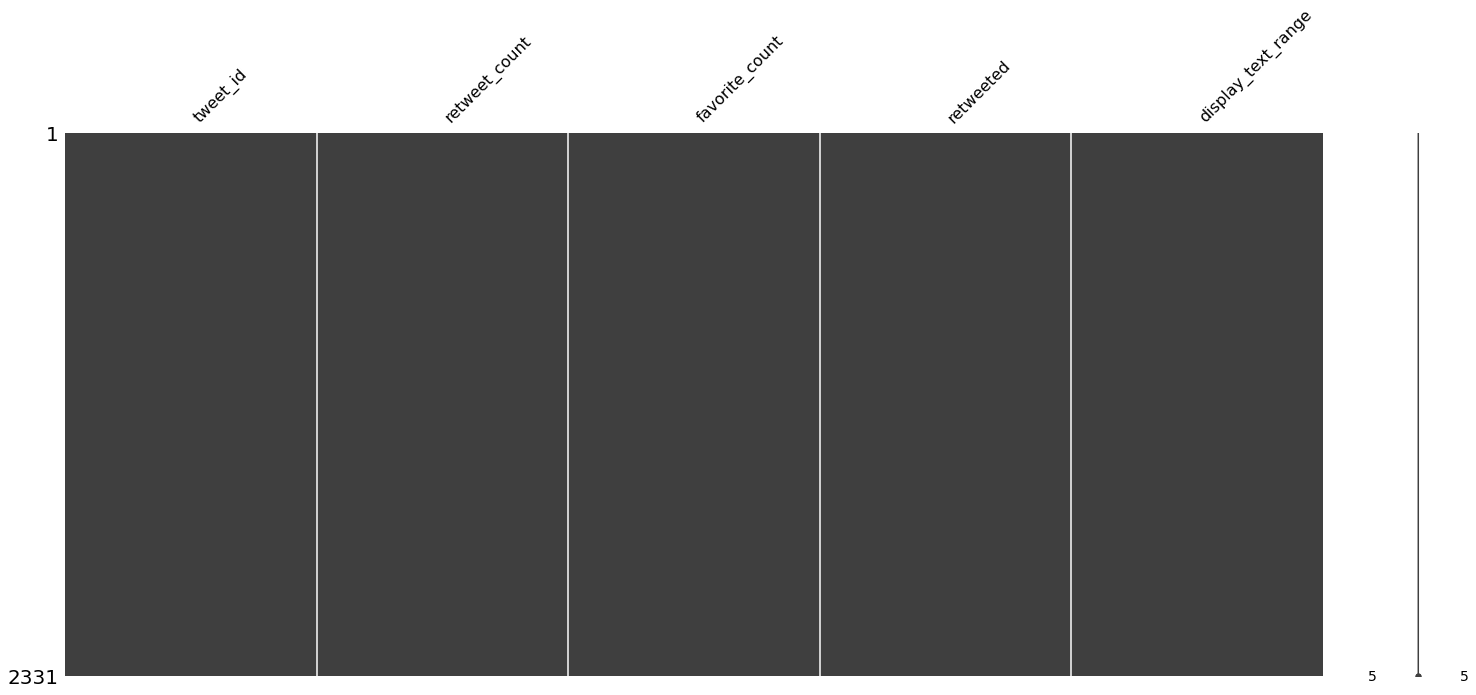

In [487]:
ms.matrix(df_api)

In [488]:
df_api.sample(10)

,tweet_id,retweet_count,favorite_count,retweeted,display_text_range
2227,667801013445750784,93,317,False,"[0, 36]"
1099,730427201120833536,1047,3481,False,"[0, 98]"
867,759793422261743616,1937,6021,False,"[0, 120]"
375,826204788643753985,938,4937,False,"[0, 116]"
645,790946055508652032,4812,17049,False,"[0, 90]"
674,787111942498508800,6907,0,False,"[0, 99]"
2258,667200525029539841,249,592,False,"[0, 139]"
2126,669682095984410625,129,344,False,"[0, 93]"
1631,683391852557561860,2396,7633,False,"[0, 133]"
1592,685198997565345792,667,2342,False,"[0, 140]"


In [489]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
tweet_id              2331 non-null int64
retweet_count         2331 non-null int64
favorite_count        2331 non-null int64
retweeted             2331 non-null bool
display_text_range    2331 non-null object
dtypes: bool(1), int64(3), object(1)
memory usage: 75.2+ KB


Overall it looks good for this dataset. There is no missing data - only the datatype of the tweet_id should again be a string.

<a id='assessmentsum'></a>
### Assessment Summary

#### Quality
##### `df_twitter` table
- The datatype of the id - columns is integer and should be str
- The datatype of the timestamp - column is object and should be datetime
- Some of the dogs are not classified as one of "doggo", "floofer", "pupper" or "puppo" and contain all "None" instead
- Some of the dog names are not correct (None, an, by, a, ...)
- Contains retweets
- Some of the ratings are not correctly extracted (mostly if there are >1 entries with the pattern `(\d+(\.\d+)?\/\d+(\.\d+)?)`)
- Also transforming the ratings to integer created some mistakes (there are also floats)
- The source column contains html code

##### `df_predict` table
- The datatype of the id - columns is integer and should be str
- Contains retweets (duplicated rows in column `jpg_url`)
- There are pictures in this table that are not dogs
- The predictions are sometimes uppercase, sometimes lowercase
- Also there is a "_" instead of a whitespace in the predictions

##### `df_api` table
- The datatype of the id - columns is integer and should be str

#### Tidiness

##### `df_twitter` table
- The columns `doggo`, `floofer`,`pupper` and `puppo` are not easy to analyze and should be in one column

##### `df_predict` table
- The prediction and confidence columns should be reduced to two columns - one for the prediction with the highest confidence (dog)

##### `df_api` table
- Display_text_range contains 2 variables

##### `all` tables

- All three tables share the column `tweet_id` and should be merged together.

<a id='cleaning'></a>
## Data Cleaning

Cleaning steps:

- Merge the tables together
- Drop the replies, retweets and the corresponding columns and also drop the tweets without an image or with images which don't display doggos
- Clean the datatypes of the columns
- Clean the wrong numerators - the floats on the one hand (replacement), the ones with multiple occurence of the pattern on the other (drop)
- Extract the source from html code
- Split the text range into two separate columns
- Remove the "None" out of the doggo, floofer, pupper and puppo column and merge them into one column
- Remove the wrong names of name column
- Reduce the prediction columns into two - breed and conf
- Clean the new breed column by replacing the "_" with a whitespace and make them all lowercase


#### 1. Merge the tables together

I could clean all the tables one by one, but all of them share some cleaning needs or are dependent on each other to do so (for example removing of retweets or pictures not containing dogs). By merging them all together as first step, I can save some coding time and avoid repetition. 

In [490]:
# outer join to not loose rows at first
df_master = pd.merge(df_twitter, df_api, on="tweet_id", how="outer")

df_master = pd.merge(df_master, df_predict, on="tweet_id", how="outer")

In [491]:
df_master_clean = df_master.copy()

In [492]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 32 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 23

#### 2. Drop the replies, retweets and the corresponding columns and also drop the tweets without an image or with images which don't display doggos

Now that this is done, we have to remove the replies, retweets and the tweets without an image displaying a dog, because we only want original tweets with images. Let's visualize our missing data first.

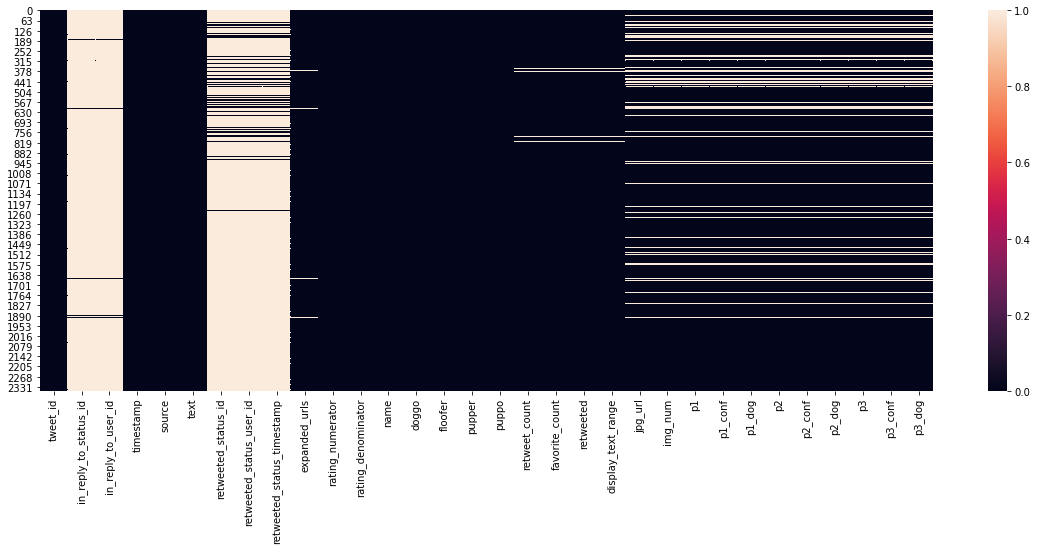

In [493]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(df_master_clean.isnull(), vmin=0, vmax=1)

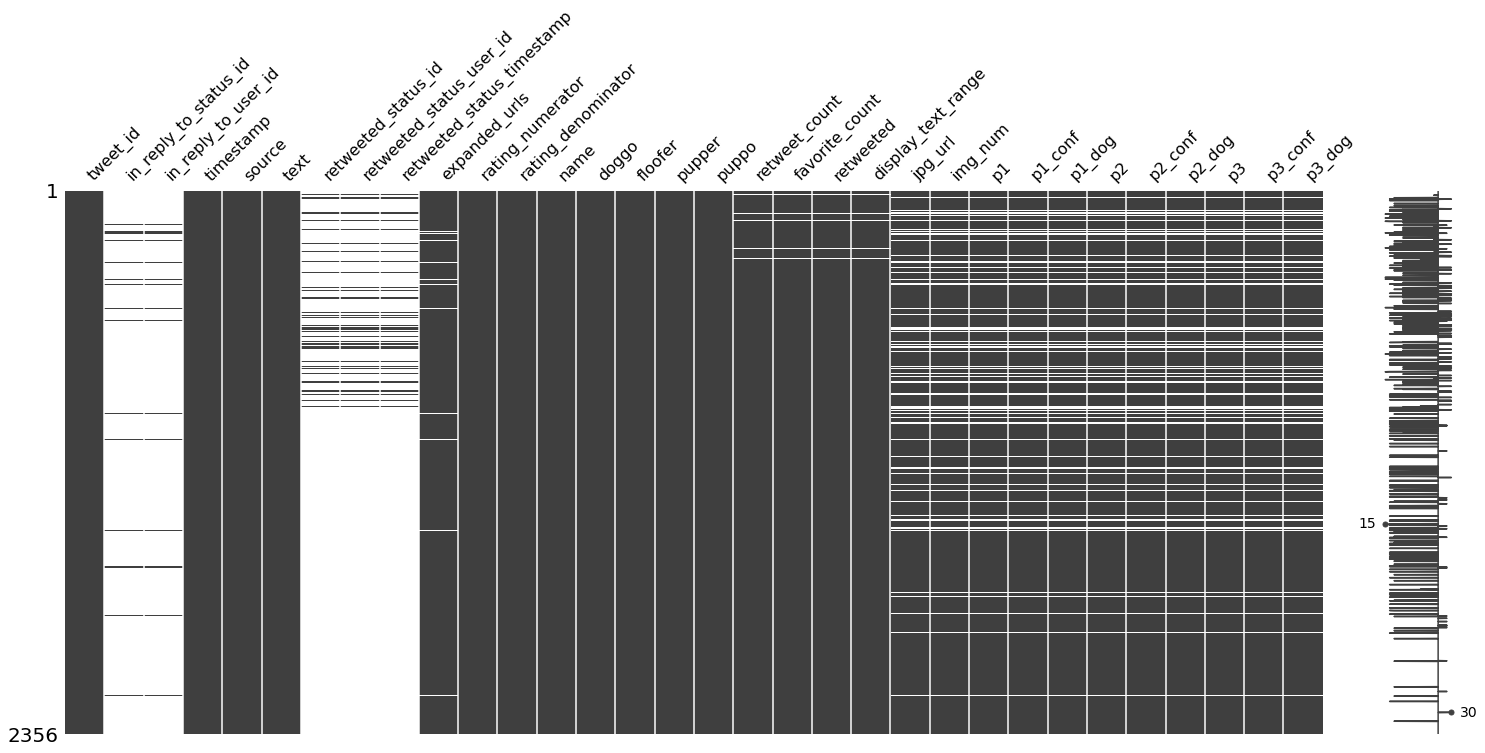

In [494]:
ms.matrix(df_master_clean)

In [495]:
pd.set_option("display.max_colwidth", 50)
df_master_clean[df_master_clean["retweeted"].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,retweeted,display_text_range,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2.0,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1.0,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
101,872668790621863937,NaN,NaN,2017-06-08 04:17:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @loganamnosis: Penelope here is doing me qu...,8.726576e+17,1.547674e+08,2017-06-08 03:32:35 +0000,https://twitter.com/loganamnosis/status/872657...,14,10,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,872261713294495745,NaN,NaN,2017-06-07 01:19:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Harry. His ears are activated one at a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872261713...,13,10,Harry,None,None,None,None,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/DBrlZk2UQAAfAkd.jpg,2.0,Labrador_retriever,0.972019,True,flat-coated_retriever,0.008178,True,Chesapeake_Bay_retriever,0.007359,True
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,866816280283807744,NaN,NaN,2017-05-23 00:41:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Jamesy. He gives a kiss...,8.664507e+17,4.196984e+09,2017-05-22 00:28:40 +0000,https://twitter.com/dog_rates/status/866450705...,13,10,Jamesy,None,None,pupper,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Good afternoon class today we'...",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,https://twitter.com/dog_rates/status/806629075...,13,10,None,None,None,None,None,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2.0,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
182,856602993587888130,NaN,NaN,2017-04-24 20:17:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Luna. It's her first ti...,8.447048e+17,4.196984e+09,2017-03-23 00:18:10 +0000,https://twitter.com/dog_rates/status/844704788...,13,10,Luna,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,851953902622658560,NaN,NaN,2017-04-12 00:23:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Astrid. She's a guide d...,8.293743e+17,4.196984e+09,2017-02-08 17:00:26 +0000,https://twitter.com/dog_rates/status/829374341...,13,10,Astrid,doggo,None,None,None,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1.0,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay

In [496]:
# we only want the rows without an entry in "retweeted_status_id" in our master dataframe
df_master_clean = df_master_clean[df_master_clean["retweeted_status_id"].isnull()]

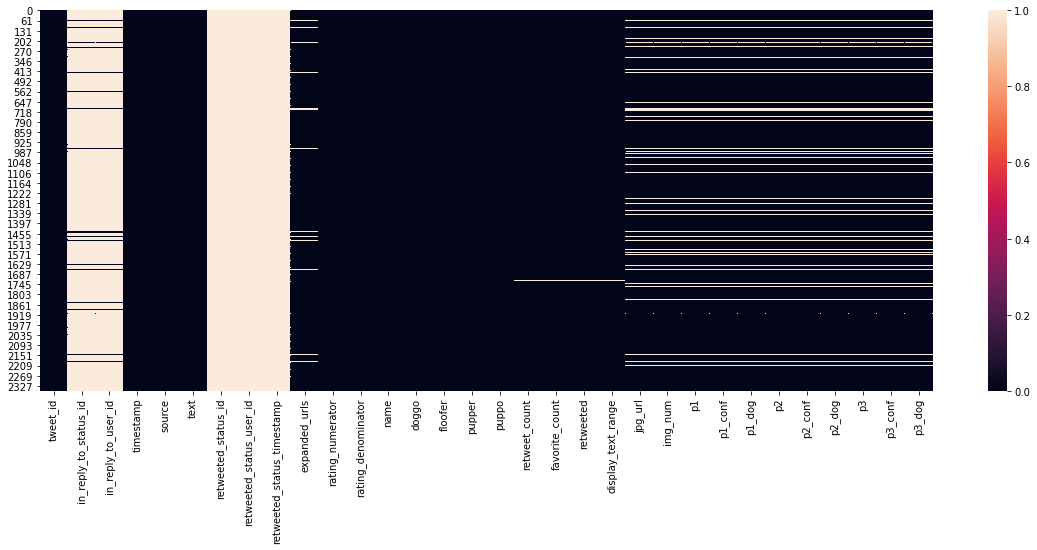

In [497]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(df_master_clean.isnull(), vmin=0, vmax=1)

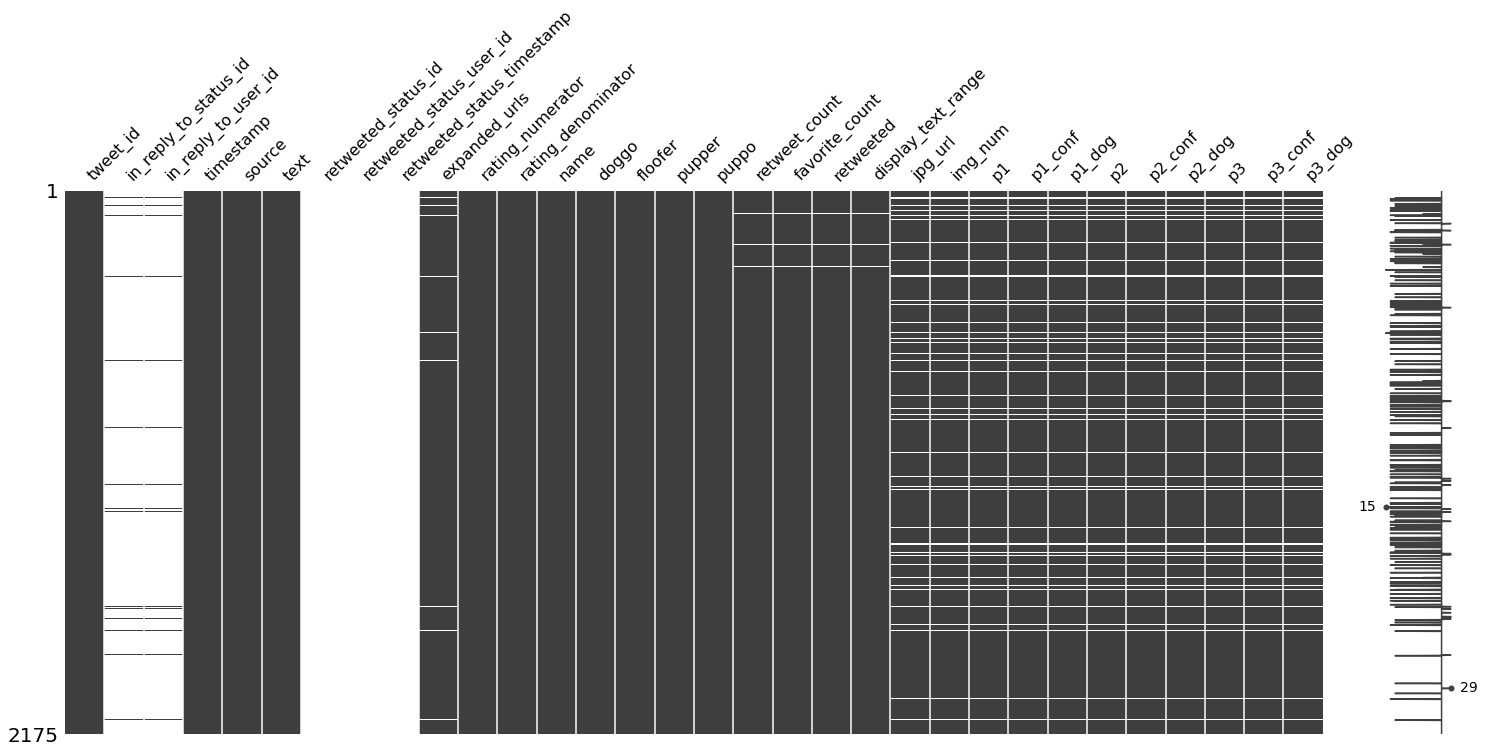

In [498]:
ms.matrix(df_master_clean)

In [499]:
df_master_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'retweet_count', 'favorite_count', 'retweeted', 'display_text_range',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [500]:
# check with the column from the api table, no retweets left
df_master_clean.retweeted.value_counts()

False    2168
Name: retweeted, dtype: int64

In [501]:
# same as for the retweets, we only want the rows without an entry in "in_reply_to_status_id"
df_master_clean = df_master_clean[df_master_clean.in_reply_to_status_id.isnull()]

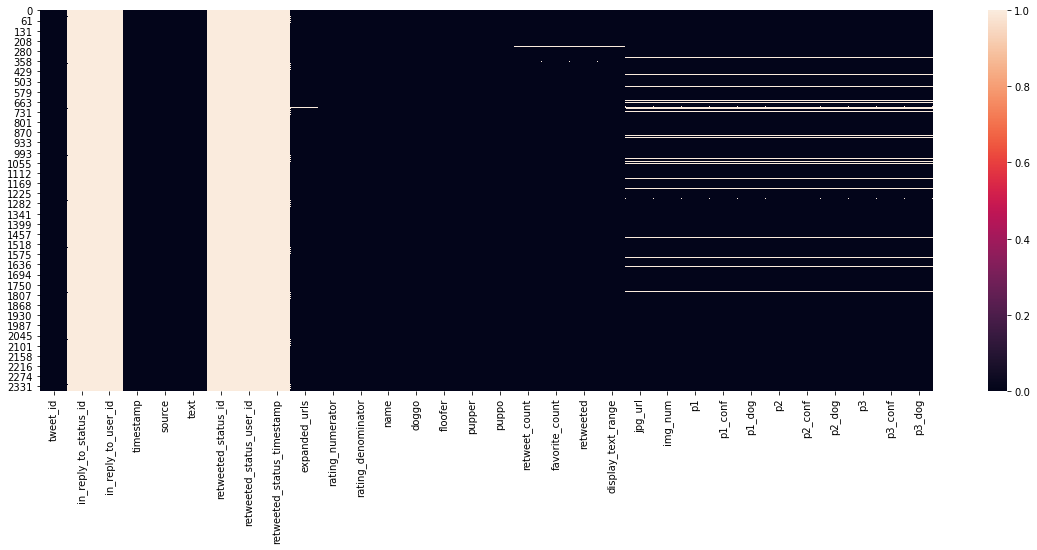

In [502]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(df_master_clean.isnull(), vmin=0, vmax=1)

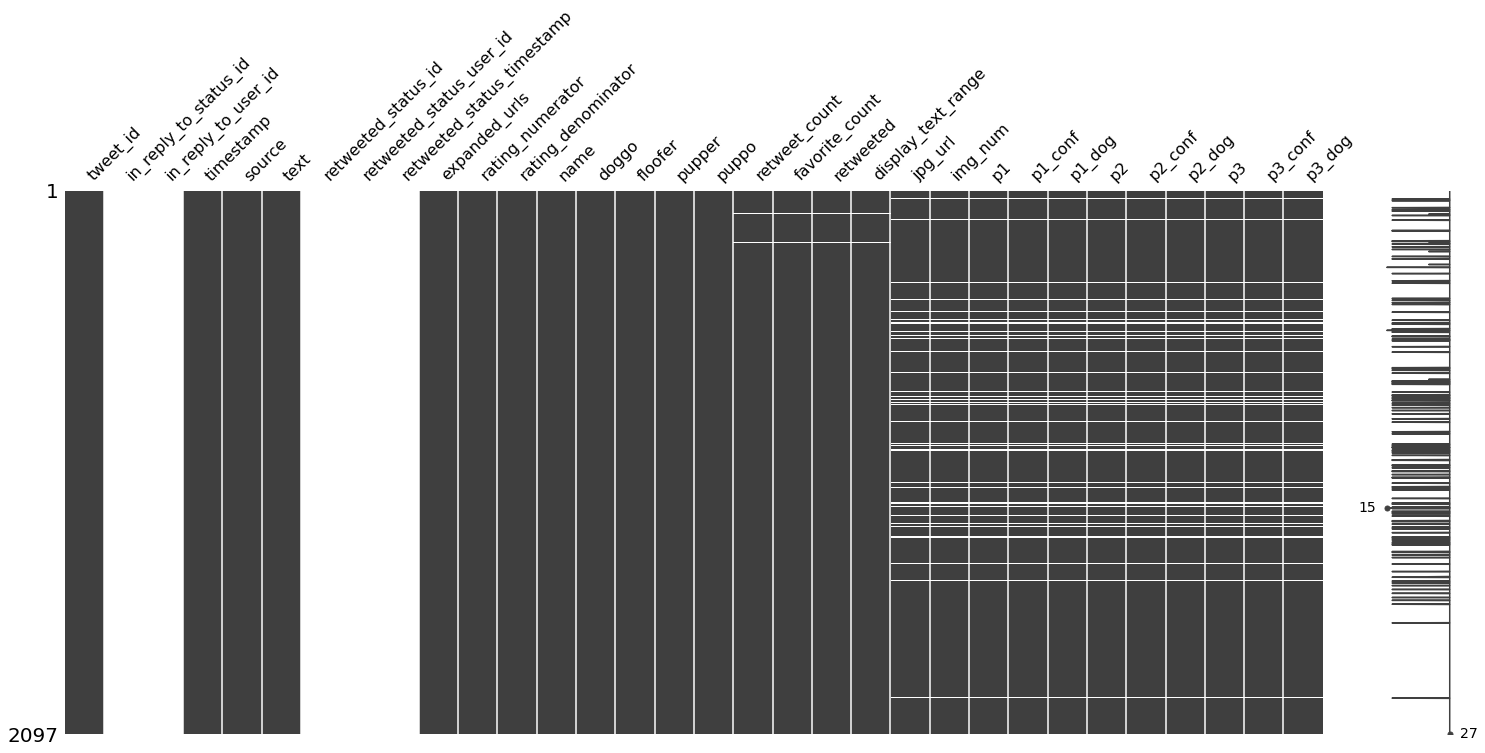

In [503]:
ms.matrix(df_master_clean)

During the gathering process from the API there were some tweets, which got deleted by the account. We will also drop them out of our master dataframe.

In [504]:
df_master_clean.dropna(subset=["retweeted"], inplace=True)

In [505]:
# drop the unneeded columns
df_master_clean.drop(
    [
        "in_reply_to_status_id",
        "in_reply_to_user_id",
        "retweeted_status_id",
        "retweeted_status_user_id",
        "retweeted_status_timestamp",
        "retweeted",
    ],
    inplace=True,
    axis=1,
)

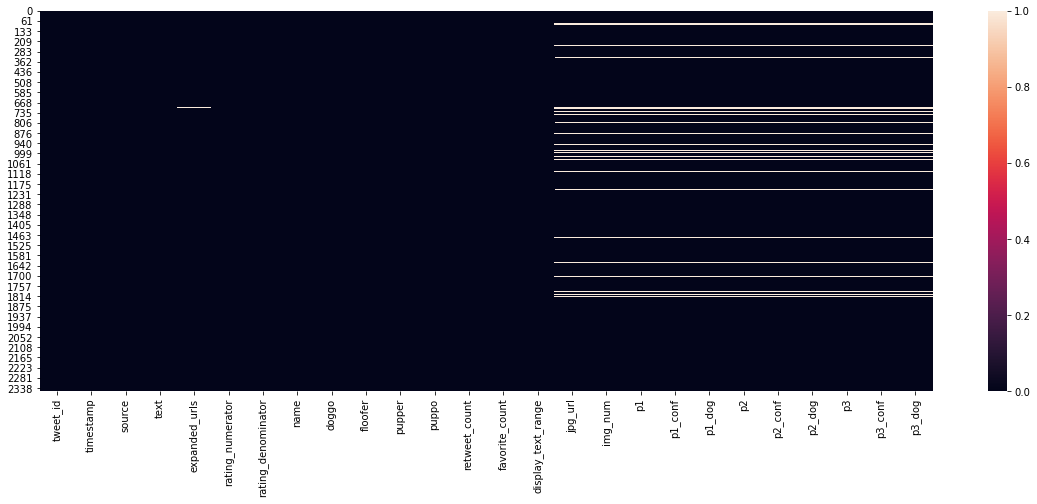

In [506]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(df_master_clean.isnull(), vmin=0, vmax=1)

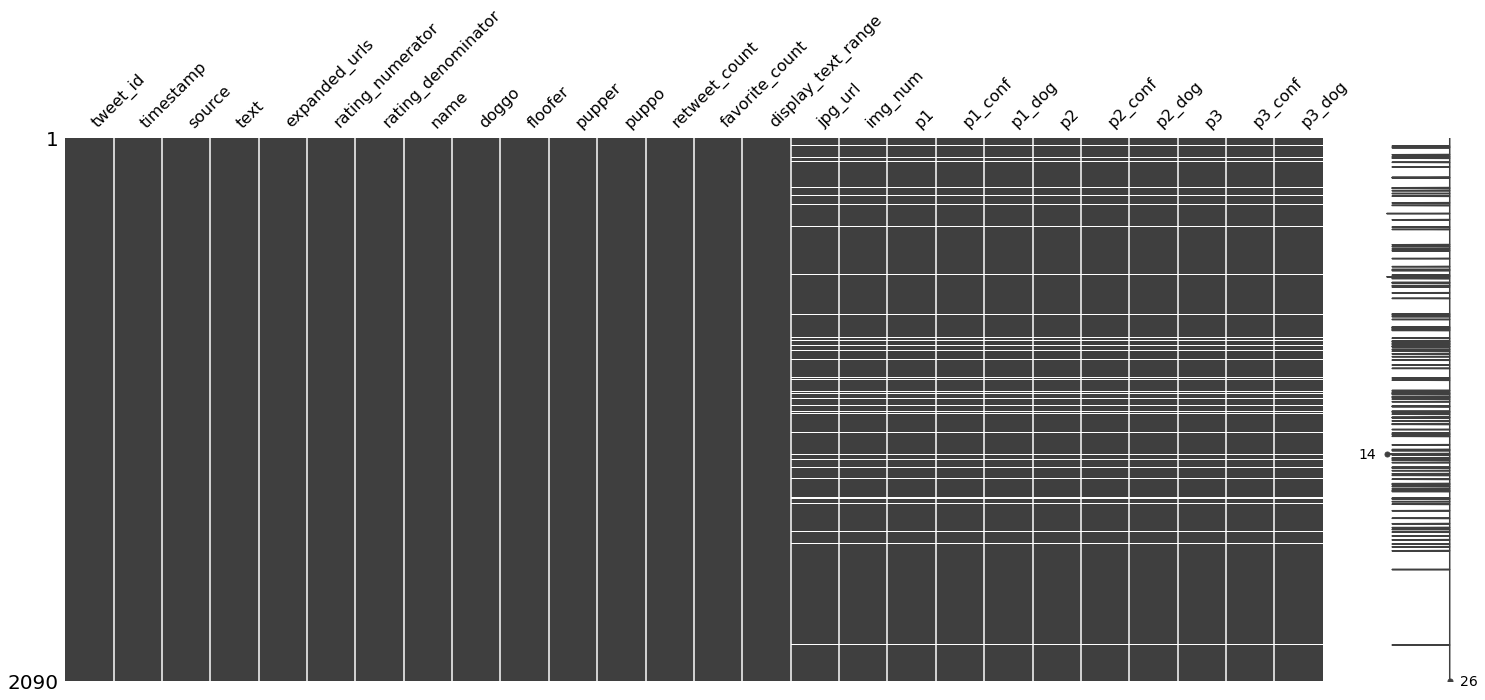

In [507]:
ms.matrix(df_master_clean)

Now we want to take a look on the "jpg_url" column and drop all the rows, which are NAN - since these are the ones without an image. To check that, we could read in the image data from the gathered API data - but I will leave this for another time.

In [508]:
df_master_clean.dropna(subset=["jpg_url"], inplace=True)

In [509]:
# check if there are still duplicated images after dropping the replies and the retweets
sum(df_master_clean.jpg_url.duplicated())

0

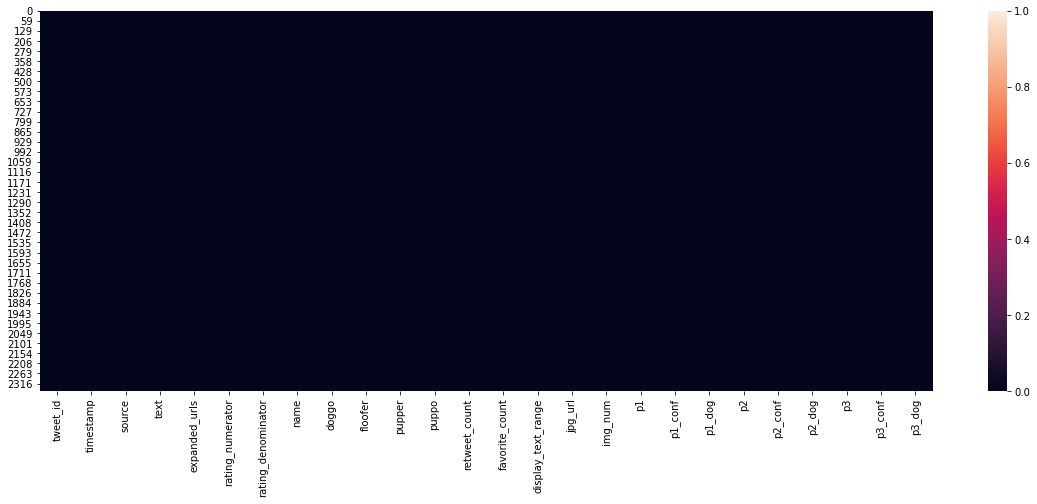

In [510]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(df_master_clean.isnull(), vmin=0, vmax=1)

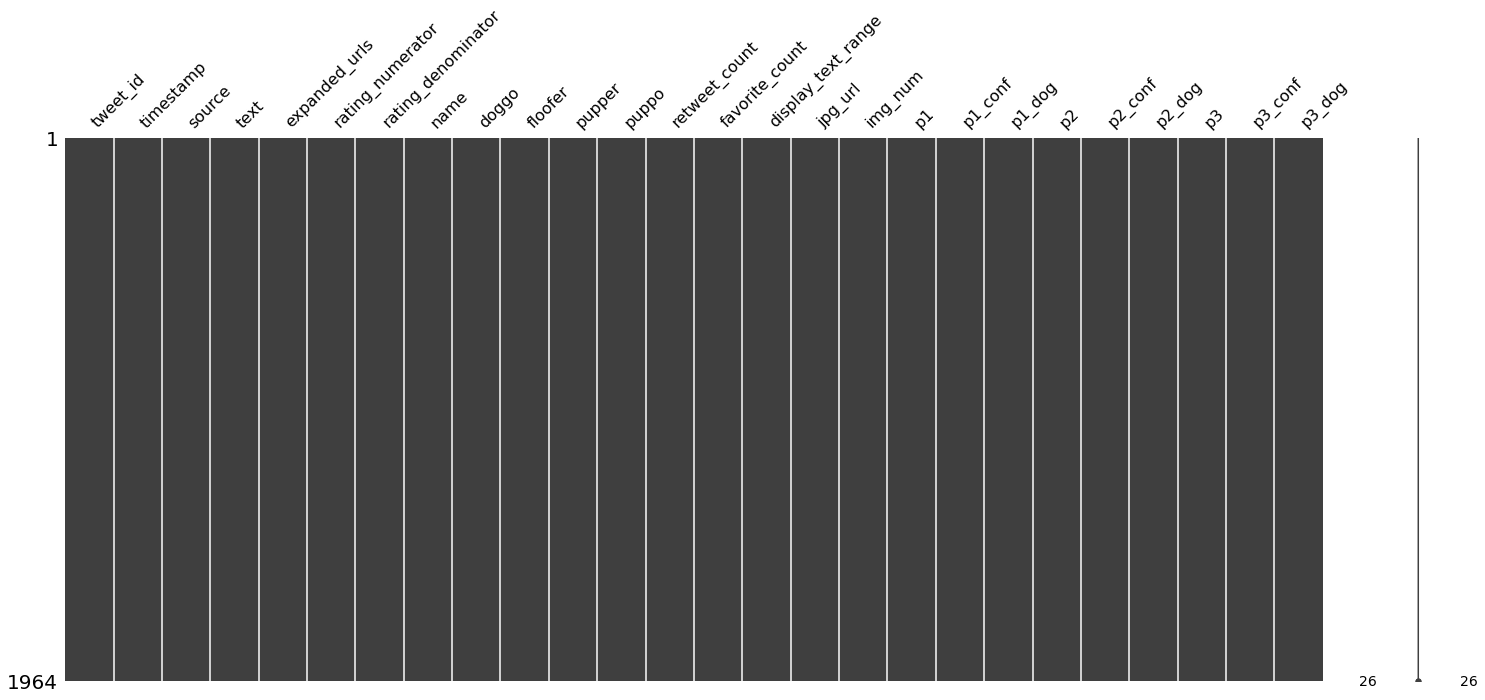

In [511]:
ms.matrix(df_master_clean)

The last step here is to drop the rows which contain images, that are not displaying any dogs (relying on the top three predictions of the ML algorithm).

In [512]:
df_master_clean.drop(
    df_master_clean.query(
        "p1_dog == False and p2_dog == False and p3_dog == False"
    ).index,
    inplace=True,
)

In [513]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1659 entries, 1 to 2355
Data columns (total 26 columns):
tweet_id              1659 non-null int64
timestamp             1659 non-null object
source                1659 non-null object
text                  1659 non-null object
expanded_urls         1659 non-null object
rating_numerator      1659 non-null int64
rating_denominator    1659 non-null int64
name                  1659 non-null object
doggo                 1659 non-null object
floofer               1659 non-null object
pupper                1659 non-null object
puppo                 1659 non-null object
retweet_count         1659 non-null float64
favorite_count        1659 non-null float64
display_text_range    1659 non-null object
jpg_url               1659 non-null object
img_num               1659 non-null float64
p1                    1659 non-null object
p1_conf               1659 non-null float64
p1_dog                1659 non-null object
p2                    1659 non-n

#### 4. Clean the wrong numerators - the floats on the one hand, the ones with multiple occurrence of the pattern on the other

While assessing the dataset, we found out, that floating numbers got transformed into integers, which lead to loss of information.

In [514]:
df_twitter_assess.query("check_num == False")[["rating_numerator", "num", "check_num"]]

,rating_numerator,num,check_num
45,5,13.5,False
340,75,9.75,False
387,7,007,False
695,75,9.75,False
763,27,11.27,False
1689,5,9.5,False
1712,26,11.26,False


We dropped a lot of rows, so we cannot be sure that all of these problems are still in this dataset, so we will extract it again.

In [515]:
pattern = "(\d+\.\d+\/\d+)"

df_master_clean.text.str.extract(pattern, expand=True)[0].dropna()

45       13.5/10
695      9.75/10
763     11.27/10
1712    11.26/10
Name: 0, dtype: object

In [516]:
# get the right numerator out of the string
df_num_clean = (
    df_master_clean.text.str.extract(pattern, expand=True)[0]
    .dropna()
    .str.split("/", n=1, expand=True)[0]
)

In [517]:
df_num_clean

45       13.5
695      9.75
763     11.27
1712    11.26
Name: 0, dtype: object

In [518]:
# get the index of the wrong data
df_num_clean_index = df_num_clean.index
df_num_clean_values = df_num_clean.values.astype("float64")

Now that we have our data together, we can impute these values and clean this data.

In [519]:
# transform the datatypes to float
df_master_clean.rating_numerator = df_master_clean.rating_numerator.astype("float64")
df_master_clean.rating_denominator = df_master_clean.rating_denominator.astype(
    "float64"
)
# impute the data
df_master_clean.loc[df_num_clean_index, "rating_numerator"] = df_num_clean_values
df_master_clean.loc[df_num_clean_index].rating_numerator

45      13.50
695      9.75
763     11.27
1712    11.26
Name: rating_numerator, dtype: float64

We also have the problem, that there can be multiple occurrences of the pattern. The reason for this is - most of the time, the display of two or more dogs in an image. For this cases we could add the ratings up, because the author of the Twitter account did this in one case that we found. Or we could build the average rating per each picture. For now, we are going to drop them out of the dataframe.

In [520]:
pattern = "(\d+(\.\d+)?\/\d+(\.\d+)?)"

print(
    df_master_clean.text.str.count(pattern)[
        df_master_clean.text.str.count(pattern) != 1
    ]
)

# get the index of the rows which contains the pattern more than once
pattern_clean_index = df_master_clean.text.str.count(pattern)[
    df_master_clean.text.str.count(pattern) != 1
].index

766     2
1007    2
1068    2
1165    2
1202    2
1222    2
1359    2
1465    2
1508    2
1525    2
1538    2
1662    2
1795    2
1832    2
1897    2
1901    2
1970    2
2010    3
2064    2
2113    2
2177    2
2216    2
2263    2
2272    2
2306    2
2335    2
Name: text, dtype: int64


In [521]:
df_master_clean.drop(pattern_clean_index, inplace=True)

In [522]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1633 entries, 1 to 2355
Data columns (total 26 columns):
tweet_id              1633 non-null int64
timestamp             1633 non-null object
source                1633 non-null object
text                  1633 non-null object
expanded_urls         1633 non-null object
rating_numerator      1633 non-null float64
rating_denominator    1633 non-null float64
name                  1633 non-null object
doggo                 1633 non-null object
floofer               1633 non-null object
pupper                1633 non-null object
puppo                 1633 non-null object
retweet_count         1633 non-null float64
favorite_count        1633 non-null float64
display_text_range    1633 non-null object
jpg_url               1633 non-null object
img_num               1633 non-null float64
p1                    1633 non-null object
p1_conf               1633 non-null float64
p1_dog                1633 non-null object
p2                    1633 n

In [523]:
# no more occurrences of the mentioned problem are left
print(
    df_master_clean.text.str.count(pattern)[
        df_master_clean.text.str.count(pattern) != 1
    ]
)

Series([], Name: text, dtype: int64)


#### 5. Extract the source from html code

Right now the source column is not giving us any useful information while looking at it. Because the relevant information is always between two "> <", the information will be easy to extract.

In [524]:
df_master_clean.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,display_text_range,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None,5721.0,31299.0,"[0, 138]",https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None,3786.0,23580.0,"[0, 121]",https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [525]:
df_master_clean.source = df_master_clean.source.str.extract("\>(.*?)\<", expand=True)

In [526]:
df_master_clean.iloc[:, :3].head(2)

,tweet_id,timestamp,source
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone


In [527]:
df_master_clean.source.value_counts()

Twitter for iPhone    1605
Twitter Web Client      20
TweetDeck                8
Name: source, dtype: int64

#### 6. Split the text range into two separate columns

In [528]:
df_master_clean[["display_text_range"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1633 entries, 1 to 2355
Data columns (total 1 columns):
display_text_range    1633 non-null object
dtypes: object(1)
memory usage: 25.5+ KB


In [529]:
df_master_clean.display_text_range[1]

[0, 138]

Since the display_text_range column is interpreted as list, we can simply split it by using list indexing.

In [530]:
# get the lower text range at list index 0
df_master_clean["lower_text_range"] = df_master_clean["display_text_range"].apply(
    lambda x: x[0]
)

# get the lower text range at list index 1
df_master_clean["upper_text_range"] = df_master_clean["display_text_range"].apply(
    lambda x: x[1]
)
df_master_clean.drop("display_text_range", axis=1, inplace=True)

In [531]:
df_master_clean[["lower_text_range", "upper_text_range"]].head()

,lower_text_range,upper_text_range
1,0,138
2,0,121
3,0,79
4,0,138
5,0,138


#### 7. Remove the "None" out of the doggo, floofer, pupper and puppo column and merge them into one column

We want to reduce the columns into one for an easier analysis. For that we have to remove the None with "" at first to concatenate the columns together and afterwards with np.nan, so we could easily exclude these rows from a specific analysis.

In [532]:
for x in ["doggo", "floofer", "pupper", "puppo"]:
    df_master_clean[x].replace("None", "", inplace=True)

# concat the columns together
df_master_clean["dog_class"] = (
    df_master_clean["doggo"].map(str)
    + df_master_clean["floofer"].map(str)
    + df_master_clean["pupper"].map(str)
    + df_master_clean["puppo"].map(str)
)

In [533]:
df_master_clean.dog_class.value_counts()

                1379
pupper           164
doggo             53
puppo             21
floofer            7
doggopupper        7
doggofloofer       1
doggopuppo         1
Name: dog_class, dtype: int64

In [534]:
df_master_clean["dog_class"].replace("", np.nan, inplace=True)

In [535]:
df_master_clean.dog_class.value_counts()

pupper          164
doggo            53
puppo            21
floofer           7
doggopupper       7
doggofloofer      1
doggopuppo        1
Name: dog_class, dtype: int64

In [536]:
# count the occurrences of the pattern and show the rows with count > 1
df_master_clean.text.str.count(r"(\bpuppo\b|\bdoggo\b|\bfloofer\b|\bpupper\b)")[
    df_master_clean.text.str.count(r"(\bpuppo\b|\bdoggo\b|\bfloofer\b|\bpupper\b)") > 1
]

191     2
531     3
575     2
889     2
956     2
1063    2
1113    2
1304    2
1340    2
1367    2
1653    2
1788    2
1828    2
1907    3
Name: text, dtype: int64

As we can see there are cases, in which there were multiple classifications. Let's extract the classes from the text and see where the differences occur.

In [537]:
df_master_clean["dog_class_re"] = df_master_clean.text.str.extract(
    r"(\bpuppo\b|\bdoggo\b|\bfloofer\b|\bpupper\b)", expand=True
)

In [538]:
# show the full text
pd.set_option("display.max_colwidth", -1)

# find the differences of the extract
df_master_clean[["text", "dog_class", "dog_class_re"]].dropna(
    subset=["dog_class_re"]
).query("dog_class != dog_class_re")

,text,dog_class,dog_class_re
191,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,doggopuppo,puppo
200,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",doggofloofer,doggo
531,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,doggopupper,pupper
575,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,doggopupper,doggo
889,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",doggopupper,doggo
956,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,doggopupper,doggo
1063,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,doggopupper,pupper
1113,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggopupper,doggo


The difference occurs in 8 cases. We can read through the text and extract the correct dog_class. Afterwards we can impute the correct classes into the column - for cases, in which there are multiple dogs in it, we will impute np.nan for consistency.

- 191 -> puppo
- 200 -> floofer
- 531 -> two dogs
- 575 -> pupper
- 889 -> two dogs
- 956 -> not classified by author
- 1063 -> two dogs
- 1113 -> two dogs

In [539]:
df_master_clean.loc[191, "dog_class"] = "puppo"
df_master_clean.loc[200, "dog_class"] = "floofer"
df_master_clean.loc[531, "dog_class"] = np.nan
df_master_clean.loc[575, "dog_class"] = "pupper"
df_master_clean.loc[889, "dog_class"] = np.nan
df_master_clean.loc[956, "dog_class"] = np.nan
df_master_clean.loc[1063, "dog_class"] = np.nan
df_master_clean.loc[1113, "dog_class"] = np.nan

In [540]:
# find the differences of the extracted classes
df_master_clean[["text", "dog_class", "dog_class_re"]].dropna(
    subset=["dog_class_re"]
).query("dog_class != dog_class_re")

,text,dog_class,dog_class_re
200,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",floofer,doggo
531,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,pupper
575,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,pupper,doggo
889,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,doggo
956,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,NaN,doggo
1063,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,NaN,pupper
1113,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",NaN,doggo


In [541]:
df_master_clean.drop(
    ["doggo", "floofer", "pupper", "puppo", "dog_class_re"], inplace=True, axis=1
)

Similar to the multiple occurrence of a pattern for the numerator, we should do the same check here.

In [542]:
# count the occurrences of the pattern and show the rows with count > 1
df_master_clean[["text", "dog_class"]].loc[
    df_master_clean.text.str.count(r"(\bpuppo\b|\bdoggo\b|\bfloofer\b|\bpupper\b)")[
        df_master_clean.text.str.count(r"(\bpuppo\b|\bdoggo\b|\bfloofer\b|\bpupper\b)")
        > 1
    ].index
]

,text,dog_class
191,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,puppo
531,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN
575,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,pupper
889,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN
956,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,NaN
1063,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,NaN
1113,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",NaN
1304,"""I shall trip the big pupper with leash. Big pupper will never see it coming. I am a genius."" Both 11/10 https://t.co/uQsCJ8pf51",pupper
1340,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu,pupper
1367,"This is Sansa. She's gotten too big for her chair. Not so smol anymore. 11/10 once a pupper, always a pupper https://t.co/IpAoztle2s",pupper


All these look correct. Let's move on.

#### 8. Remove the wrong names of name column

Here we will also replace the wrong names with np.nan.

In [543]:
for x in ["None", "a", "by", "the"]:
    df_master_clean["name"].replace(x, np.nan, inplace=True)

In [544]:
df_master_clean.name.value_counts()

Cooper     10
Tucker     9 
Charlie    9 
Lucy       9 
Oliver     9 
          .. 
Trigger    1 
Tedrick    1 
Joshwa     1 
Stu        1 
CeCe       1 
Name: name, Length: 833, dtype: int64

In [545]:
df_master_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,lower_text_range,upper_text_range,dog_class
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,5721.0,31299.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,0,138,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,3786.0,23580.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,0,121,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,7884.0,39619.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,0,79,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,8512.0,37814.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,0,138,NaN
5,891087950875897856,2017-07-29 00:08:17 +0000,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,10.0,NaN,2847.0,19051.0,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,0,138,NaN


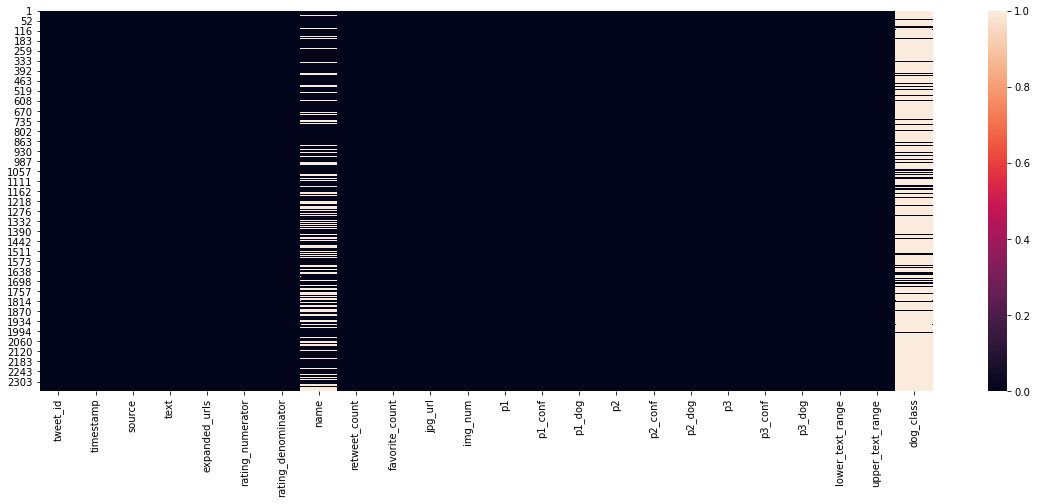

In [546]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(df_master_clean.isnull(), vmin=0, vmax=1)

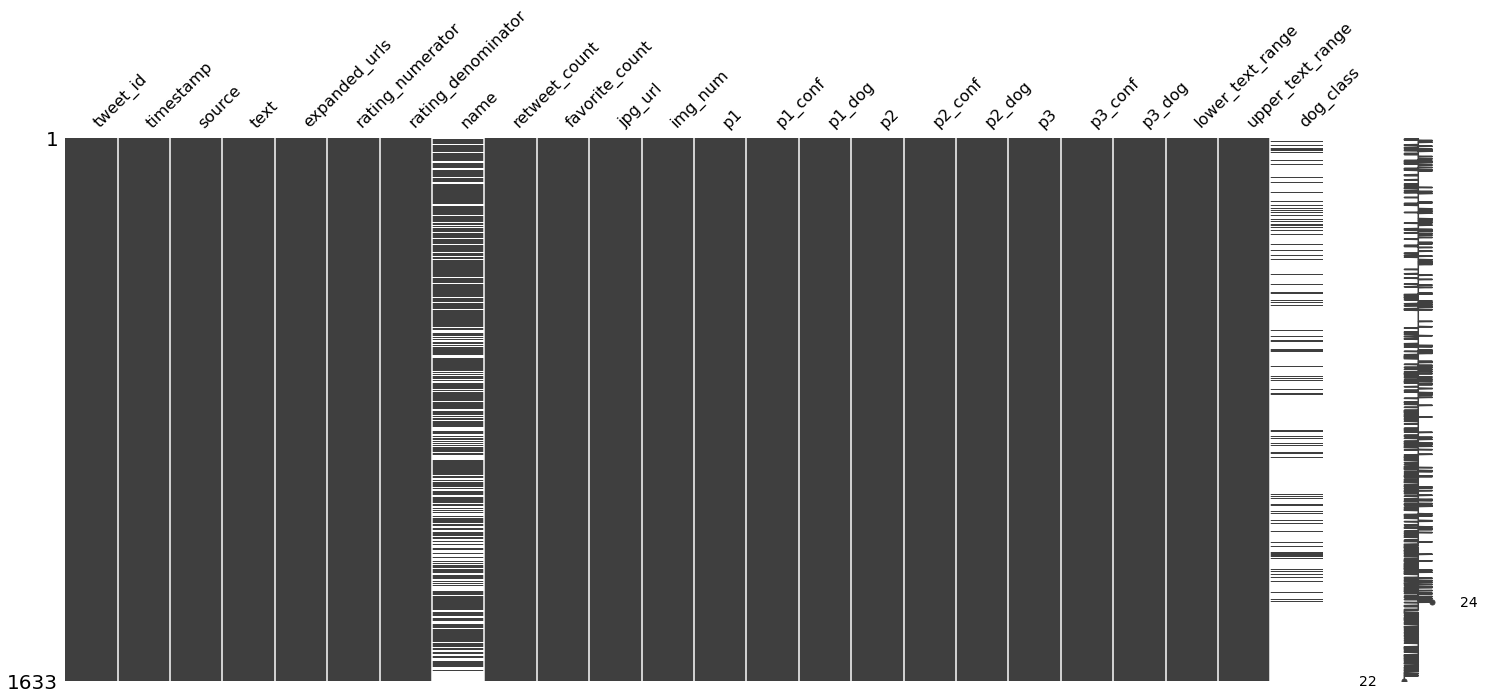

In [547]:
ms.matrix(df_master_clean)

In [548]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1633 entries, 1 to 2355
Data columns (total 24 columns):
tweet_id              1633 non-null int64
timestamp             1633 non-null object
source                1633 non-null object
text                  1633 non-null object
expanded_urls         1633 non-null object
rating_numerator      1633 non-null float64
rating_denominator    1633 non-null float64
name                  1190 non-null object
retweet_count         1633 non-null float64
favorite_count        1633 non-null float64
jpg_url               1633 non-null object
img_num               1633 non-null float64
p1                    1633 non-null object
p1_conf               1633 non-null float64
p1_dog                1633 non-null object
p2                    1633 non-null object
p2_conf               1633 non-null float64
p2_dog                1633 non-null object
p3                    1633 non-null object
p3_conf               1633 non-null float64
p3_dog                1633

#### 9. Reduce the prediction columns into two - breed and confidence

In the next step we want to reduce the prediction columns into two - breed and confidence. The columns are already sorted by confidence. We will take the most likely prediction for each row which is supposed to be a dog.

In [549]:
df_master_clean.query("p2_conf > p1_conf")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,lower_text_range,upper_text_range,dog_class


In [550]:
df_master_clean.query("p3_conf > p1_conf")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,lower_text_range,upper_text_range,dog_class


In [551]:
df_master_clean.query("p3_conf > p2_conf")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,lower_text_range,upper_text_range,dog_class


The order is correct.

In [552]:
# extract the most likely prediction which is a dog
def get_attributes(columns):
    """
    INPUT: 
        Columns in this order: Check1, Result1, Check2, Result2, Result3
    OUTPUT:
        Results based on the check in this columns
    """
    if columns[0] == True:
        return columns[1]
    elif columns[2] == True:
        return columns[3]
    else:
        return columns[4]

In [553]:
df_master_clean["breed"] = df_master_clean[
    ["p1_dog", "p1", "p2_dog", "p2", "p3"]
].apply(get_attributes, axis=1)
df_master_clean["conf"] = df_master_clean[
    ["p1_dog", "p1_conf", "p2_dog", "p2_conf", "p3_conf"]
].apply(get_attributes, axis=1)

In [554]:
df_master_clean.iloc[:, 12:]

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,lower_text_range,upper_text_range,dog_class,breed,conf
1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,0,138,NaN,Chihuahua,0.323581
2,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,0,121,NaN,Chihuahua,0.716012
3,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,0,79,NaN,Labrador_retriever,0.168086
4,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,0,138,NaN,basset,0.555712
5,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,0,138,NaN,Chesapeake_Bay_retriever,0.425595
6,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,0,140,NaN,Appenzeller,0.341703
7,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,0,118,NaN,Pomeranian,0.566142
8,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,0,122,NaN,Irish_terrier,0.487574
9,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,0,133,doggo,Pembroke,0.511319
10,Samoyed,0.957979,True,Pomeranian,0.013884,True,chow,0.008167,True,0,130,NaN,Samoyed,0.957979


In [555]:
df_master_clean.drop(df_master_clean.columns[12:21], inplace=True, axis=1)

In [556]:
df_master_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,lower_text_range,upper_text_range,dog_class,breed,conf
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,5721.0,31299.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,0,138,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,3786.0,23580.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,0,121,NaN,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,7884.0,39619.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,0,79,NaN,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,8512.0,37814.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,0,138,NaN,basset,0.555712
5,891087950875897856,2017-07-29 00:08:17 +0000,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,10.0,NaN,2847.0,19051.0,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,0,138,NaN,Chesapeake_Bay_retriever,0.425595


#### 10. Clean the new breed column by replacing the "_" with a whitespace and make them all lowercase

Now that we have our reduced column, we have to clean it for consistency.

In [557]:
df_master_clean.breed = df_master_clean.breed.str.replace("_", " ")

In [558]:
df_master_clean.breed

1       Chihuahua               
2       Chihuahua               
3       Labrador retriever      
4       basset                  
5       Chesapeake Bay retriever
                  ...           
2351    miniature pinscher      
2352    Rhodesian ridgeback     
2353    German shepherd         
2354    redbone                 
2355    Welsh springer spaniel  
Name: breed, Length: 1633, dtype: object

In [559]:
df_master_clean.breed = df_master_clean.breed.str.lower()

In [560]:
df_master_clean.breed.value_counts().head(10)

golden retriever      154
labrador retriever    103
pembroke              93 
chihuahua             87 
pug                   62 
toy poodle            49 
chow                  48 
samoyed               41 
pomeranian            39 
malamute              33 
Name: breed, dtype: int64

In [561]:
df_master_clean.reset_index(drop=True, inplace=True)

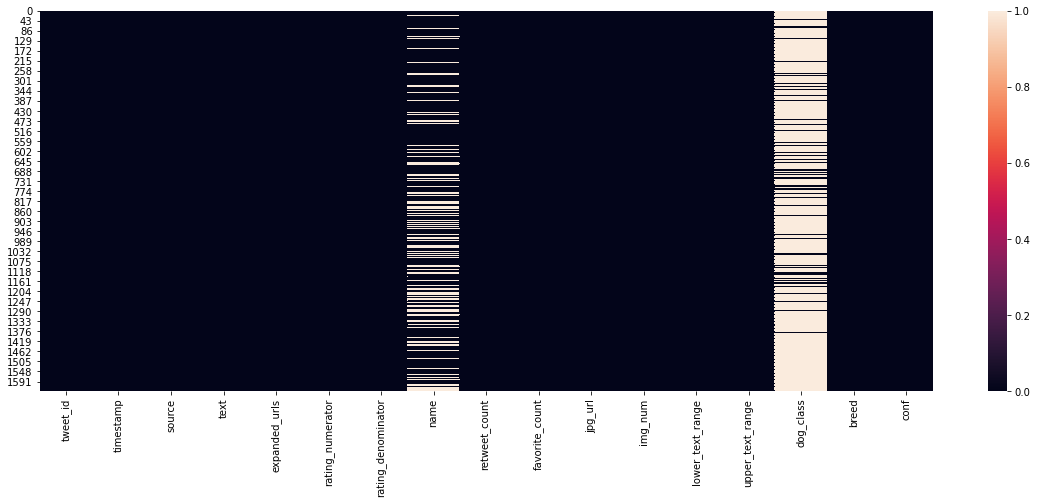

In [562]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(df_master_clean.isnull(), vmin=0, vmax=1)

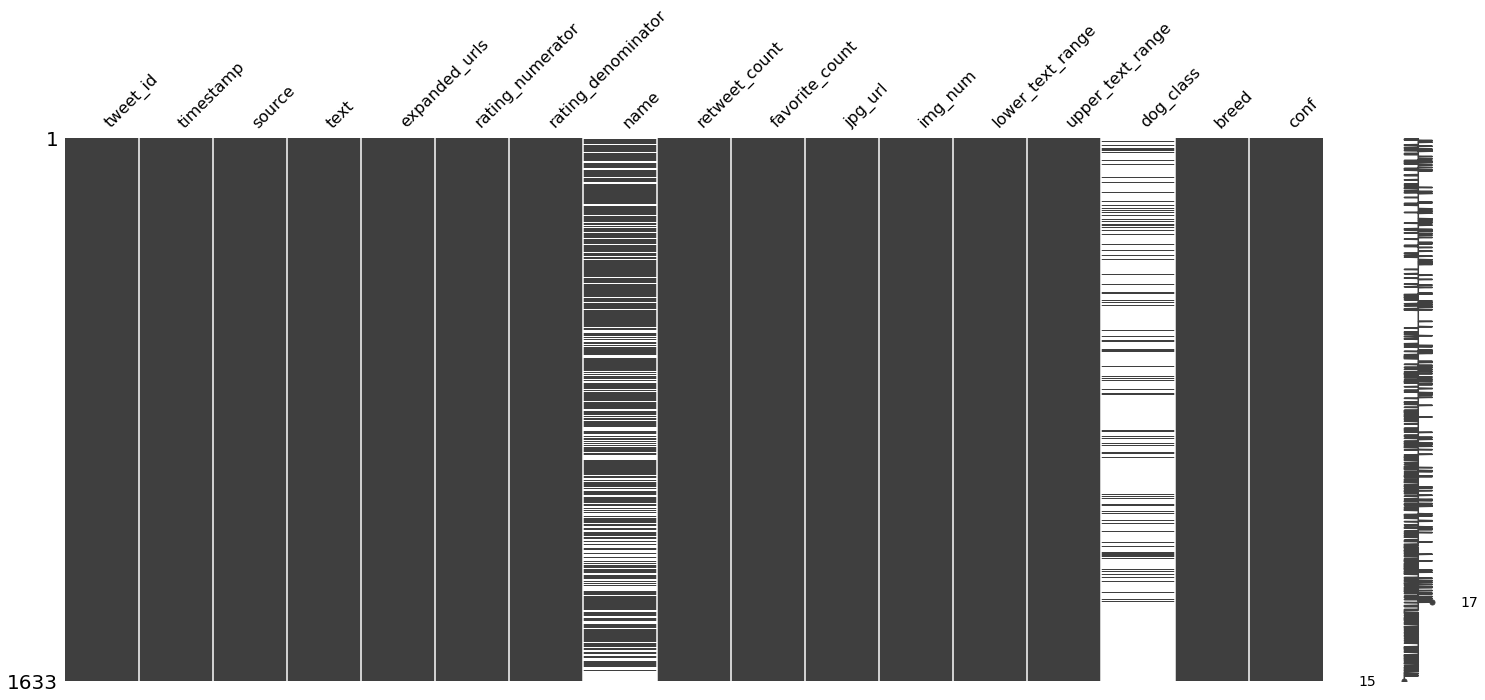

In [563]:
ms.matrix(df_master_clean)

In [564]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 17 columns):
tweet_id              1633 non-null int64
timestamp             1633 non-null object
source                1633 non-null object
text                  1633 non-null object
expanded_urls         1633 non-null object
rating_numerator      1633 non-null float64
rating_denominator    1633 non-null float64
name                  1190 non-null object
retweet_count         1633 non-null float64
favorite_count        1633 non-null float64
jpg_url               1633 non-null object
img_num               1633 non-null float64
lower_text_range      1633 non-null int64
upper_text_range      1633 non-null int64
dog_class             249 non-null object
breed                 1633 non-null object
conf                  1633 non-null float64
dtypes: float64(6), int64(3), object(8)
memory usage: 217.0+ KB


In [565]:
df_master_clean[["breed", "conf"]].head(3)

,breed,conf
0,chihuahua,0.323581
1,chihuahua,0.716012
2,labrador retriever,0.168086


Finally the data is clean. Let's save it for analysis

In [566]:
df_master_clean.to_csv("../data/processed/twitter_archive_master.csv", index=False)

<a id='analysis'></a>
## Data Analysis

### Questions

1. Based on the predictions, most liked dog breed: Which breed gets retweeted and favorited the most overall?
2. How did the account develop (speaking about number of tweets, retweets, favorites, image number and length of the tweets)? 
3. Is there a pattern visible in the timing of the tweets?

#### 1. Based on the predictions, most liked dog breed: Which breed gets retweeted and favorited the most?

To answer this question we will first take a look on the frequency of the breed occurrence and afterwards we will create a groupby object to sum up the favorite and retweet count of each breed in this dataset.

In [567]:
df = pd.read_csv("../data/processed/twitter_archive_master.csv")

In [568]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,lower_text_range,upper_text_range,dog_class,breed,conf
0,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,5721.0,31299.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,0,138,NaN,chihuahua,0.323581
1,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,3786.0,23580.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,0,121,NaN,chihuahua,0.716012
2,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,7884.0,39619.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,0,79,NaN,labrador retriever,0.168086
3,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,8512.0,37814.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,0,138,NaN,basset,0.555712
4,891087950875897856,2017-07-29 00:08:17 +0000,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,10.0,NaN,2847.0,19051.0,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,0,138,NaN,chesapeake bay retriever,0.425595


In [569]:
df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'retweet_count',
       'favorite_count', 'jpg_url', 'img_num', 'lower_text_range',
       'upper_text_range', 'dog_class', 'breed', 'conf'],
      dtype='object')

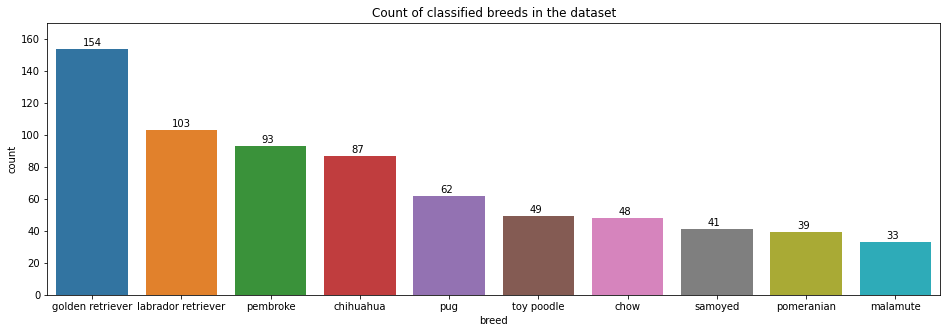

In [570]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.countplot(x="breed", data=df, order=df.breed.value_counts().iloc[:10].index)
ax.set_title("Count of classified breeds in the dataset")

ax.set_ylim(0, 170)

for p in ax.patches:
    ax.annotate("{:.0f}".format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 2))

The dogs displayed in the images are mostly golden retrievers with a count of 154 or labrador retrievers with a count of 105.

In [571]:
df_breed_group = (
    df[["retweet_count", "favorite_count", "breed"]]
    .groupby("breed", as_index=False)
    .sum()
)

df_breed_group.sort_values("retweet_count", ascending=False).head(10)

,breed,retweet_count,favorite_count
45,golden retriever,506592.0,1768222.0
62,labrador retriever,348163.0,1124588.0
80,pembroke,258908.0,970774.0
27,chihuahua,213344.0,680499.0
88,samoyed,170864.0,518109.0
41,french bulldog,144623.0,563542.0
30,cocker spaniel,127543.0,368809.0
28,chow,117777.0,419646.0
82,pug,103915.0,351101.0
81,pomeranian,99884.0,294923.0


In [572]:
df_breed_group.sort_values("favorite_count", ascending=False).head(10)

,breed,retweet_count,favorite_count
45,golden retriever,506592.0,1768222.0
62,labrador retriever,348163.0,1124588.0
80,pembroke,258908.0,970774.0
27,chihuahua,213344.0,680499.0
41,french bulldog,144623.0,563542.0
88,samoyed,170864.0,518109.0
28,chow,117777.0,419646.0
30,cocker spaniel,127543.0,368809.0
82,pug,103915.0,351101.0
66,malamute,97116.0,328232.0


The golden retriever and the labrador retriever therefore also lead the list of most favorite and retweets.

In [573]:
df_breed_group["sum"] = (
    df_breed_group["retweet_count"] + df_breed_group["favorite_count"]
)

df_breed_group.sort_values("sum", ascending=False).head(10)

,breed,retweet_count,favorite_count,sum
45,golden retriever,506592.0,1768222.0,2274814.0
62,labrador retriever,348163.0,1124588.0,1472751.0
80,pembroke,258908.0,970774.0,1229682.0
27,chihuahua,213344.0,680499.0,893843.0
41,french bulldog,144623.0,563542.0,708165.0
88,samoyed,170864.0,518109.0,688973.0
28,chow,117777.0,419646.0,537423.0
30,cocker spaniel,127543.0,368809.0,496352.0
82,pug,103915.0,351101.0,455016.0
66,malamute,97116.0,328232.0,425348.0


Text(0.5, 1.0, 'Sum of favorites and retweets per breed')

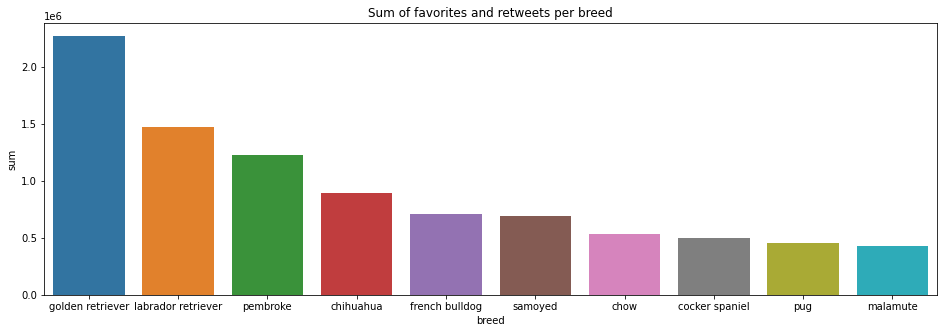

In [574]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.barplot(
    x="breed",
    y="sum",
    data=df_breed_group.sort_values("sum", ascending=False).iloc[:10],
)
ax.set_title("Sum of favorites and retweets per breed")

Now let's look at the most retweetet and favorited single tweet.

In [575]:
df[["retweet_count", "favorite_count", "breed"]].sort_values(
    "retweet_count", ascending=False
).head(5)

,retweet_count,favorite_count,breed
678,78123.0,156742.0,labrador retriever
705,57912.0,115755.0,eskimo dog
356,56967.0,121050.0,chihuahua
271,44011.0,133472.0,lakeland terrier
53,40688.0,99560.0,english springer


In [576]:
df[["retweet_count", "favorite_count", "breed"]].sort_values(
    "favorite_count", ascending=False
).head(5)

,retweet_count,favorite_count,breed
678,78123.0,156742.0,labrador retriever
271,44011.0,133472.0,lakeland terrier
356,56967.0,121050.0,chihuahua
99,33073.0,116746.0,french bulldog
705,57912.0,115755.0,eskimo dog


We can see that the most liked and retweeted tweet is in fact a labrador retriever, with golden retrievers not even being in the list. Let's see if there are big differences in the average rating.

In [577]:
df_breed_group_mean = (
    df[["rating_numerator", "breed"]].groupby("breed", as_index=False).mean()
)

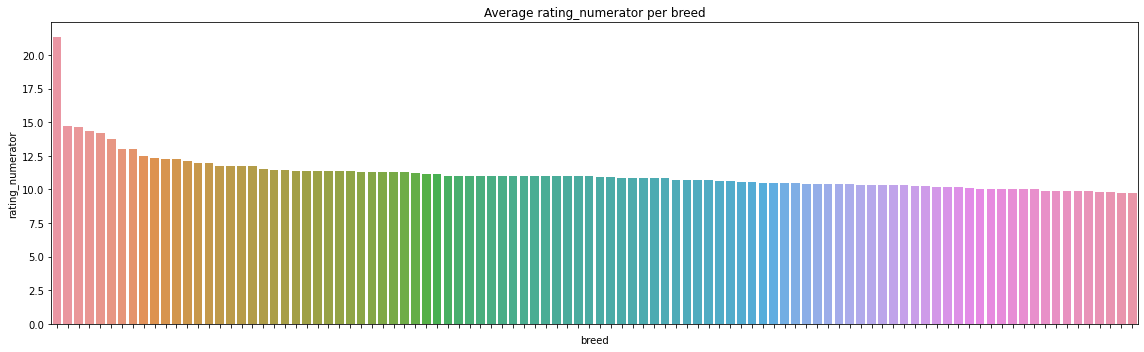

In [578]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.barplot(
    x="breed",
    y="rating_numerator",
    data=df_breed_group_mean.sort_values("rating_numerator", ascending=False).iloc[
        :100
    ],
)
ax.set_title("Average rating_numerator per breed")

ax.xaxis.set_ticklabels([])
plt.tight_layout()

While the most breeds are on average on nearly the same level of rating, there is some outlier visible.

In [579]:
df_breed_group_mean.sort_values("rating_numerator", ascending=False).head(10)

,breed,rating_numerator
96,soft-coated wheaten terrier,21.357143
109,west highland white terrier,14.687500
48,great pyrenees,14.666667
16,borzoi,14.333333
28,chow,14.166667
62,labrador retriever,13.728155
4,australian terrier,13.000000
18,bouvier des flandres,13.000000
87,saluki,12.500000
21,briard,12.333333


In [580]:
df[["breed", "rating_numerator"]].sort_values("rating_numerator", ascending=False).head(
    5
)

,breed,rating_numerator
583,labrador retriever,165.0
1222,chow,144.0
1116,soft-coated wheaten terrier,121.0
823,golden retriever,99.0
1269,labrador retriever,88.0


In [581]:
len(df.query("breed == 'labrador retriever'"))

103

In [582]:
len(df.query("breed == 'soft-coated wheaten terrier'"))

14

In [583]:
df.query("breed != 'soft-coated wheaten terrier'").rating_numerator.mean()

11.261754169240271

The soft-coated wheaten terrier	got a very high mean rating. The labrador retriever got overall the highest rating with 165, but since there are a lot more tweets with labrador retriever than for the soft-coated wheaten terrier, one of the rating of the soft-coated wheaten terrier has a higher weight than the one of the labrador retriever (14 tweets of soft-coated wheaten terrier and 105 of labrador retriever).

Not taking the outlier into account, this leads us to an average rating of 11. Based on the number of posts, retweets, favorites and mean rating, we will give the title of "Most overall liked dog of this twitter account and its community" to the labrador retriever.

#### 2. How did the account develop (speaking about number of tweets, retweets, favorites, image number and length of the tweets)?

To answer this question we first have to extract time information out of the timestamp.

In [584]:
df_time = df.copy()

In [585]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 17 columns):
tweet_id              1633 non-null int64
timestamp             1633 non-null object
source                1633 non-null object
text                  1633 non-null object
expanded_urls         1633 non-null object
rating_numerator      1633 non-null float64
rating_denominator    1633 non-null float64
name                  1190 non-null object
retweet_count         1633 non-null float64
favorite_count        1633 non-null float64
jpg_url               1633 non-null object
img_num               1633 non-null float64
lower_text_range      1633 non-null int64
upper_text_range      1633 non-null int64
dog_class             249 non-null object
breed                 1633 non-null object
conf                  1633 non-null float64
dtypes: float64(6), int64(3), object(8)
memory usage: 217.0+ KB


The timestamp is a string again, so we need to transform it again.

In [586]:
df_time.timestamp = pd.to_datetime(df_time.timestamp)

Let's first take a look on the day of the week.

In [587]:
df_time["dow"] = df_time["timestamp"].apply(lambda x: x.dayofweek)

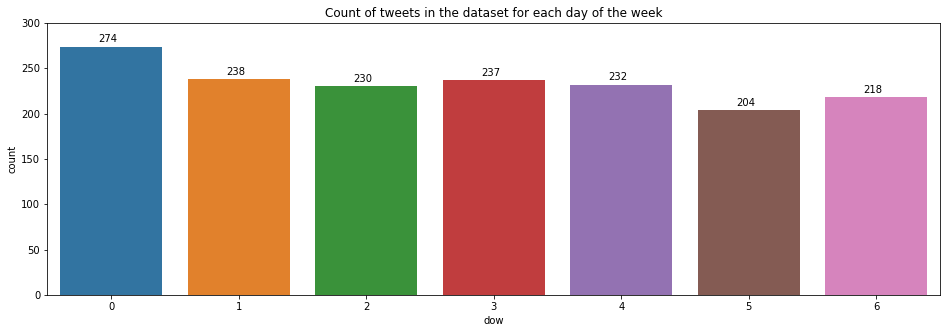

In [588]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.countplot(x="dow", data=df_time)
ax.set_title("Count of tweets in the dataset for each day of the week")

ax.set_ylim(0, 300)

for p in ax.patches:
    ax.annotate("{:.0f}".format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 5))

We can see that most of the tweets are posted on monday. For tuesday to friday it is nearly the same number of posts. On the weekend the twitter profile tweets a little bit less.

In [589]:
df_time.timestamp.min()

Timestamp('2015-11-15 22:32:08+0000', tz='UTC')

In [590]:
df_time.timestamp.max()

Timestamp('2017-08-01 00:17:27+0000', tz='UTC')

This dataset contains data from the end of 2015 to the August of 2017. Let's extract the month, year and hour information from the timestamp.

In [591]:
df_time["month"] = df_time["timestamp"].apply(lambda x: x.month)
df_time["year"] = df_time["timestamp"].apply(lambda x: x.year)
df_time["hour"] = df_time["timestamp"].apply(lambda x: x.hour)

For the first graph I only want to take a look on the full year 2016.

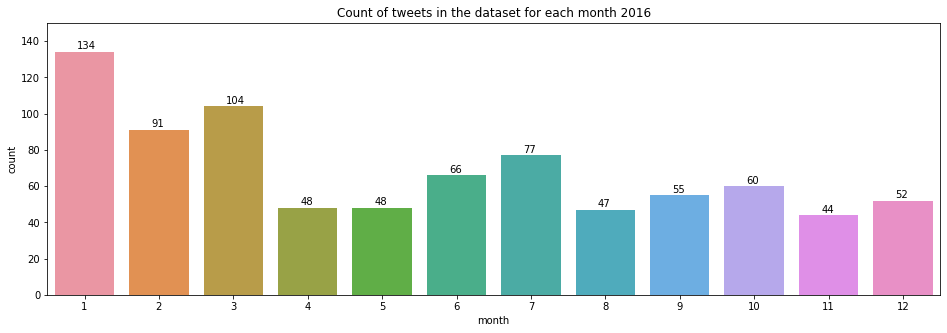

In [592]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.countplot(x="month", data=df_time.query("year == 2016"))
ax.set_title("Count of tweets in the dataset for each month 2016")

ax.set_ylim(0, 150)

for p in ax.patches:
    ax.annotate(
        "{:.0f}".format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1.5)
    )

Over the timeperiod of 2016 the number of post per months decreased. It went from 134 tweets in January to 52 in December. Does this mean, that the performance of this account is also decreasing?

In [593]:
df_time["month_year"] = pd.to_datetime(df["timestamp"]).dt.to_period("M")

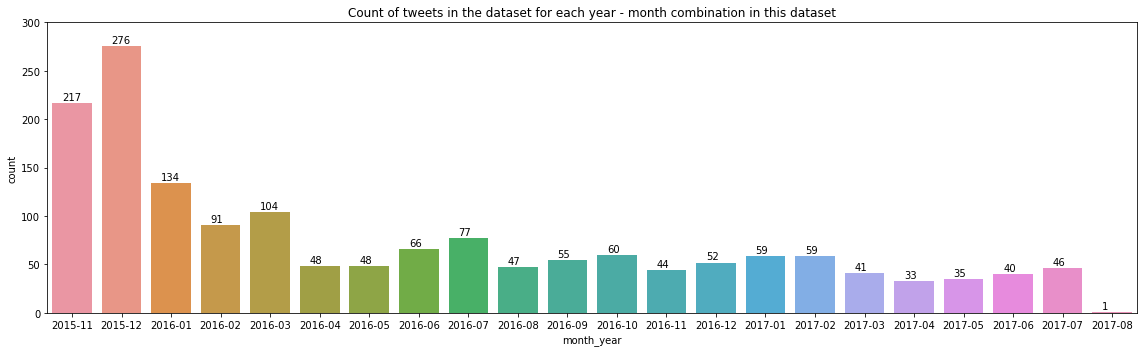

In [594]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.countplot(x="month_year", data=df_time.sort_values("month_year"))
ax.set_title(
    "Count of tweets in the dataset for each year - month combination in this dataset"
)

ax.set_ylim(0, 300)

for p in ax.patches:
    ax.annotate("{:.0f}".format(p.get_height()), (p.get_x() + 0.2, p.get_height() + 3))

plt.tight_layout()

If we look at it over the whole timeperiod it becomes even more clear. In April 2016 the number of tweets dropped and since then it has a relatively stable level. To see if the performance of the account decreased we will take a look on the favorites and retweets that the posts get.

In [595]:
df_time_groupby = df_time.groupby("month_year", as_index=False).sum()

In [596]:
df_time_groupby.head()

,month_year,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,lower_text_range,upper_text_range,conf,dow,month,year,hour
0,2015-11,1.450925e+20,2049.00,2170.0,93034.0,238103.0,220.0,0.0,26103.0,105.165214,635.0,2387.0,437255.0,1833.0
1,2015-12,1.866097e+20,2986.26,2940.0,391493.0,964061.0,299.0,0.0,31103.0,143.884391,783.0,3312.0,556140.0,2514.0
2,2016-01,9.218872e+19,1505.00,1440.0,156570.0,447470.0,152.0,0.0,15547.0,71.353070,418.0,134.0,270144.0,1082.0
3,2016-02,6.362919e+19,1033.00,980.0,114588.0,332483.0,107.0,0.0,10390.0,49.415261,256.0,182.0,183456.0,737.0
4,2016-03,7.376839e+19,1298.00,1230.0,141342.0,424912.0,123.0,0.0,12282.0,62.738141,310.0,312.0,209664.0,889.0


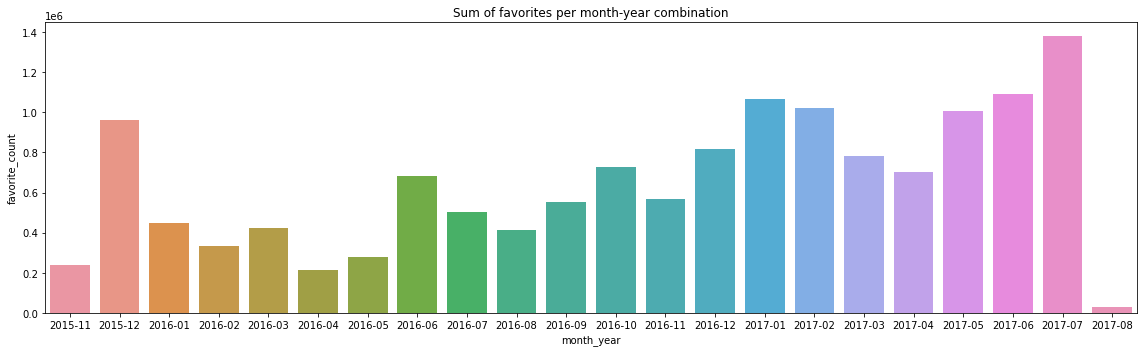

In [597]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.barplot(x="month_year", y="favorite_count", data=df_time_groupby)
ax.set_title("Sum of favorites per month-year combination")
plt.tight_layout()

Text(0.5, 1.0, 'Sum of retweets per month-year combination')

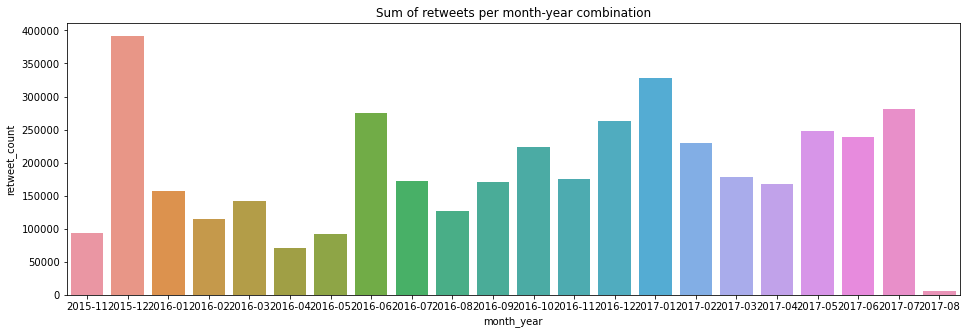

In [598]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.barplot(x="month_year", y="retweet_count", data=df_time_groupby)
ax.set_title("Sum of retweets per month-year combination")

Interesting, while the number of tweets per month is decreasing, the favorites and retweets per month are increasing.

In [599]:
df_time_groupby_mean = df_time.groupby("month_year", as_index=False).mean()

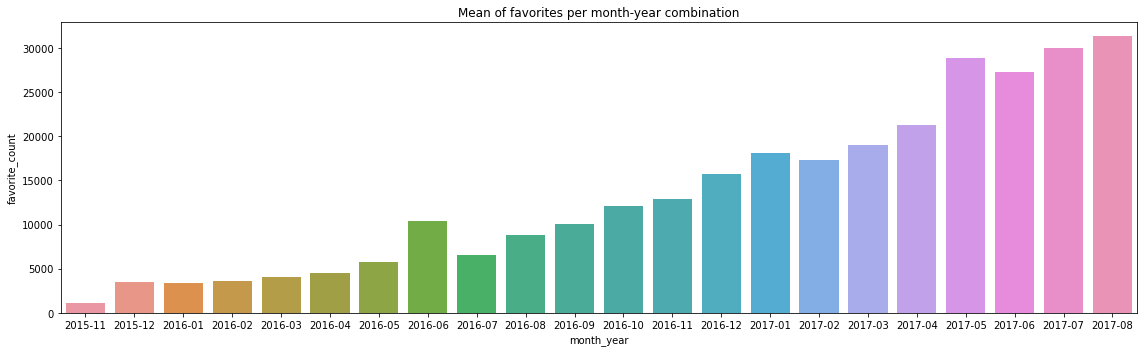

In [600]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.barplot(x="month_year", y="favorite_count", data=df_time_groupby_mean)
ax.set_title("Mean of favorites per month-year combination")
plt.tight_layout()

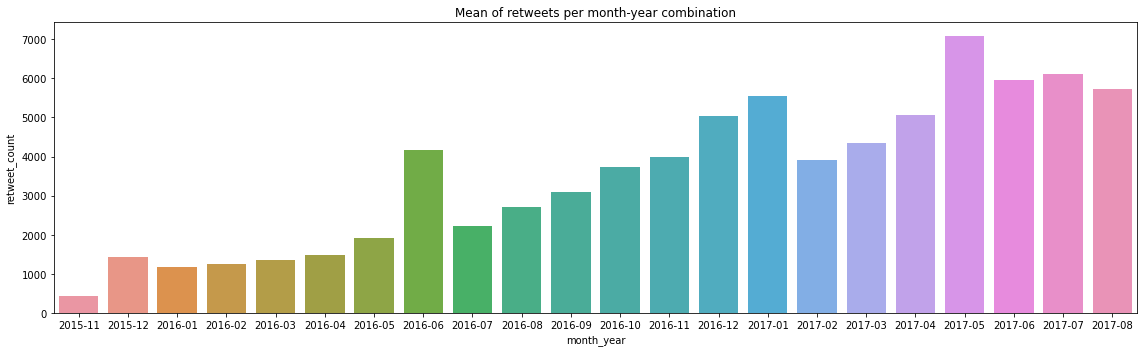

In [601]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.barplot(x="month_year", y="retweet_count", data=df_time_groupby_mean)
ax.set_title("Mean of retweets per month-year combination")
plt.tight_layout()

If we look at the average number of favorites and retweets the clear uptrend gets even more clearer! Now let's see if the number of posted images per month or the average upper text range changed over time.

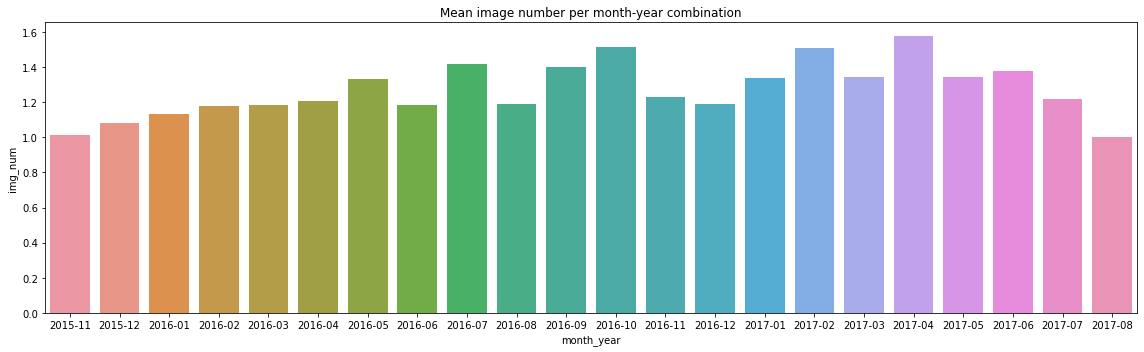

In [602]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.barplot(x="month_year", y="img_num", data=df_time_groupby_mean)
ax.set_title("Mean image number per month-year combination")
plt.tight_layout()

For the images it seems pretty stable. There are months where are more images posted and months where are less posted images, but overall there is no clear uptrend or downtrend visible.

Text(0.5, 1.0, 'Mean upper text range per month_year combination')

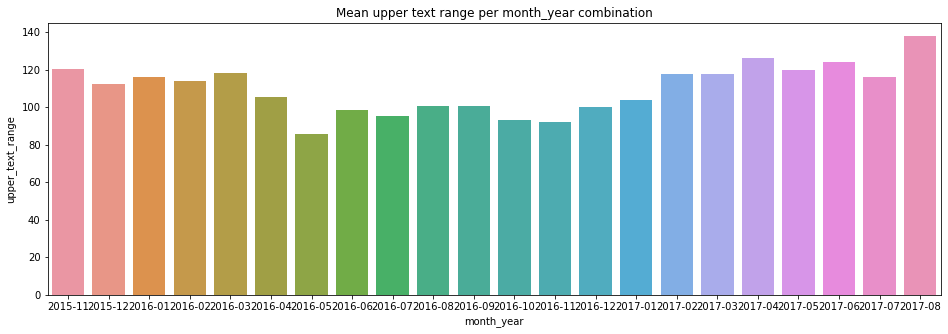

In [603]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.barplot(x="month_year", y="upper_text_range", data=df_time_groupby_mean)
ax.set_title("Mean upper text range per month_year combination")

In [604]:
df_time_groupby_mean.upper_text_range.mean()

109.8499773989006

In [605]:
df_time_groupby_mean.iloc[:11].upper_text_range.mean()

106.16802606196683

In [606]:
df_time_groupby_mean.iloc[11:].upper_text_range.mean()

113.53192873583444

For the tweet length it seems like it increased over the second half of this dataset from an average of 106 to 113.

#### 3. Is there a pattern visible in the timing of the tweets?

Text(0.5, 1.0, 'Count of tweets in the dataset for each hour in 2016')

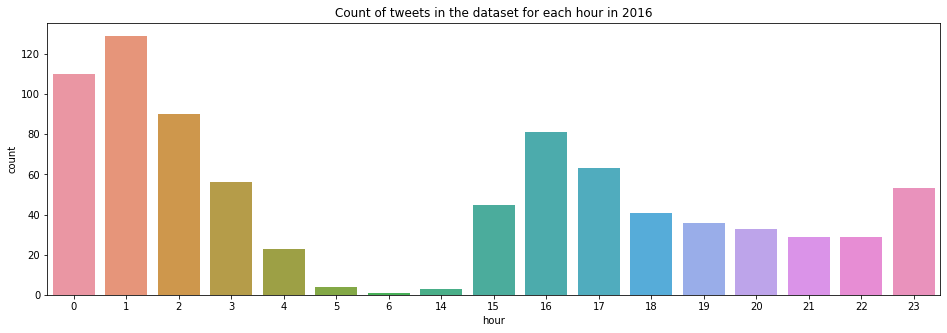

In [607]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.countplot(x="hour", data=df_time.query("year == 2016"))
ax.set_title("Count of tweets in the dataset for each hour in 2016")

Text(0.5, 1.0, 'Count of tweets in the dataset for each hour in 2015')

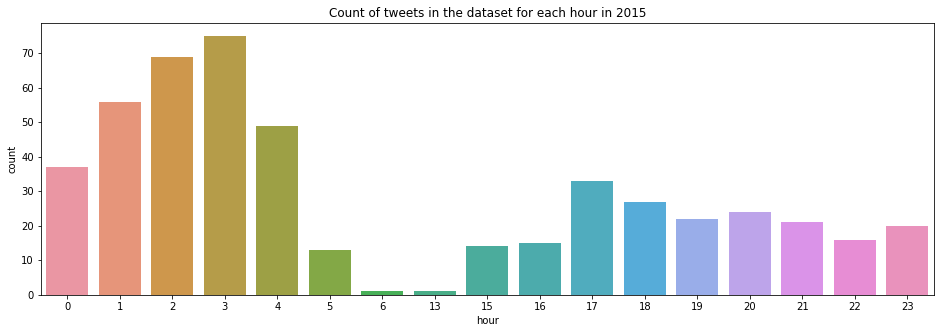

In [608]:
fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.countplot(x="hour", data=df_time.query("year == 2015"))
ax.set_title("Count of tweets in the dataset for each hour in 2015")

As we can see in these graphs of 2015 and 2016, most posts are during the night between 0 and 500hrs. Between 400 and 1500hrs there are very small amounts of tweets. There is no single tweet for the hours 700 - 1200hrs and 1400hrs. There are some tweets after 1400hrs, but not as much as between 0 and 500hrs.

<a id='#conclusion'></a>
## Summary and Conclusions

In this project we went through a whole data wrangling process. The gathering included data obtained programmatically, manually as well as using an API. Also the cleaning part covered a lot of techniques like regular expressions and the overall handling of dataframes.

In the analysis we took a look at following questions: 

1. Based on the predictions, most liked dog breed: Which breed gets retweeted and favorited the most overall?
    
    - The winner for our analysis was the labrador retriever.    


2. How did the account develop (speaking about number of tweets, retweets, favorites, image number and length of the tweets)?
    
   - We found, that the number of tweets per month decreased, while the retweets and favorites show an uptrend. For the image numbers, there is no clear trend visible, the length of the tweets got a little bit closer to the maximum of 130 in the second half of the dataset.


3. Is there a pattern visible in the timing of the tweets?
    
   - Yes, between 500 and 1500hrs there are nearly no tweets at all. Most tweets are during the time from 0 - 400hrs and then slightly less tweets from 1500 - 2300hrs.


## Sources Referred

- https://towardsdatascience.com/flattening-json-objects-in-python-f5343c794b10
- https://stackoverflow.com/questions/36028932/how-to-extract-specific-content-in-a-pandas-dataframe-with-a-regex
- https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns
- https://stackoverflow.com/questions/3075130/what-is-the-difference-between-and-regular-expressions
- https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python
- http://queirozf.com/entries/visualization-options-for-jupyter-notebooks
- https://stackoverflow.com/questions/22245171/how-to-lowercase-a-python-dataframe-string-column-if-it-has-missing-values
- https://stackoverflow.com/questions/32891211/limit-the-number-of-groups-shown-in-seaborn-countplot
- https://stackoverflow.com/questions/33179122/seaborn-countplot-with-frequencies
- https://erikrood.com/Python_References/extract_month_year_pandas_final.html
- Udacity course materials
- Library documentations